In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# --- Unzip the dataset ---
# IMPORTANT: Update this path to match the location of your zip file in Drive.
zip_path = '/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/ffhq256_10ksubset.zip'

# The destination folder in the local Colab environment.
destination_path = '/content'

print("Unzipping dataset...")
# The -q flag makes the output cleaner (quiet mode)
!unzip -q {zip_path} -d {destination_path}

print(f"✅ Dataset unzipped to {destination_path}")

Unzipping dataset...
replace /content/ffhq_subset_10k/63779.png? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
✅ Dataset unzipped to /content


In [3]:
# Install
!pip -q install pytorch_wavelets torchmetrics lpips torch-fidelity

In [43]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import torch._dynamo
from torch.utils.data import Dataset, DataLoader, Subset
from torch.nn.utils import spectral_norm
from torchvision.utils import save_image, make_grid
from torchvision import transforms
from PIL import Image
import pandas as pd
import time
import random
import math
from tqdm.auto import tqdm
from tqdm.autonotebook import tqdm
import os
import glob
import matplotlib.pyplot as plt

import torchmetrics
from torchmetrics.image.fid import FrechetInceptionDistance
import lpips

import torch.fft
from pytorch_wavelets import DWTForward
from einops import rearrange

# Enable TensorFloat32
torch.set_float32_matmul_precision('high')

# --- Configuration & Hyperparameters ---

# Set the path to your image folder in Google Drive
# IMPORTANT: Update this path to match where you saved your dataset.
DATASET_PATH = '/content/ffhq_subset_10k'
NUM_IMAGES_TO_USE_CNN = 10000
NUM_IMAGES_TO_USE_GAN = 1000

# Training settings
NUM_EPOCHS_CNN = 40
NUM_EPOCHS_GAN = 200
LEARNING_RATE = 1e-4
BATCH_SIZE = 4

# Set the device (use GPU if available)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {DEVICE}")

Using device: cuda


In [5]:
class FFHQDataset(Dataset):
    """Custom PyTorch Dataset for loading FFHQ images."""
    def __init__(self, img_dir, transform=None, num_images=None): # Add num_images parameter
        """
        Args:
            img_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied on a sample.
            num_images (int, optional): Number of images to use. If None, use all images.
        """
        # Find all files with .png or .jpg extension
        self.img_paths = glob.glob(os.path.join(img_dir, '*.png'))
        self.img_paths.extend(glob.glob(os.path.join(img_dir, '*.jpg')))
        self.transform = transform

        if num_images:
            # If a number is specified, shuffle all paths and take a random subset
            random.shuffle(self.img_paths)
            self.img_paths = self.img_paths[:num_images]

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        image = Image.open(img_path).convert('RGB')
        if self.transform:
            image = self.transform(image)
        return image

# Your transform definition remains the same
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [6]:
def tensor_to_image(tensor):
    """
    Converts a PyTorch tensor to a displayable NumPy image.
    It denormalizes, moves to CPU, and changes dimension order.
    """
    # Denormalize the image from [-1, 1] to [0, 1]
    image = tensor * 0.5 + 0.5
    # Move tensor to CPU and convert to NumPy array
    image = image.cpu().numpy()
    # Transpose dimensions from (C, H, W) to (H, W, C) for plotting
    image = image.transpose(1, 2, 0)
    # Clip values to be in the valid [0, 1] range for images
    image = np.clip(image, 0, 1)
    return image

In [7]:
def create_mask(image, mask_percentage=0.025):
    """
    Creates masks that are more likely to cover facial features.
    """
    batch_size, _, height, width = image.shape
    mask = torch.ones_like(image)

    # Face regions typically in center 60% of image
    center_bias = 0.3  # 30% border on each side

    for i in range(batch_size):
        mask_h = int(np.sqrt(height * width * mask_percentage))
        mask_w = mask_h

        # Bias towards center
        top_min = int(height * center_bias)
        top_max = int(height * (1 - center_bias)) - mask_h
        left_min = int(width * center_bias)
        left_max = int(width * (1 - center_bias)) - mask_w

        top = np.random.randint(top_min, max(top_min + 1, top_max))
        left = np.random.randint(left_min, max(left_min + 1, left_max))

        mask[i, :, top:top+mask_h, left:left+mask_w] = 0

    masked_image = image * mask
    return masked_image, mask

# CNN
For coarse inpainting.

In [8]:
class SelfAttention(nn.Module):
    """ A simple self-attention layer """
    def __init__(self, channels):
        super().__init__()
        self.query = nn.Conv2d(channels, channels // 8, 1)
        self.key   = nn.Conv2d(channels, channels // 8, 1)
        self.value = nn.Conv2d(channels, channels, 1)
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        batch_size, C, width, height = x.size()
        q = self.query(x).view(batch_size, -1, width * height).permute(0, 2, 1)
        k = self.key(x).view(batch_size, -1, width * height)
        v = self.value(x).view(batch_size, -1, width * height)

        attention_map = F.softmax(torch.bmm(q, k), dim=-1)

        out = torch.bmm(v, attention_map.permute(0, 2, 1))
        out = out.view(batch_size, C, width, height)

        return self.gamma * out + x # Add skip connection

class UpsampleBlock(nn.Module):
    """An upsampling block using Conv2d and PixelShuffle."""
    def __init__(self, in_channels, out_channels):
        super().__init__()
        # The Conv2d layer produces 4x the channels for a 2x upscale
        self.conv = nn.Conv2d(in_channels, out_channels * 4, kernel_size=3, padding=1)
        self.pixel_shuffle = nn.PixelShuffle(2) # Rearranges channels to upscale by 2x
        self.relu = nn.ReLU(inplace=True)

    def forward(self, x):
        return self.relu(self.pixel_shuffle(self.conv(x)))

class GatedConv2d(nn.Module):
    """
    A Gated Convolutional Layer.
    It learns a dynamic feature mask for each channel at every location.
    """
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1):
        super().__init__()
        # Convolution for the features
        self.conv_feature = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )
        # Convolution for the gating mechanism
        self.conv_gate = nn.Conv2d(
            in_channels, out_channels, kernel_size, stride, padding, dilation
        )

    def forward(self, x):
        # Get the features and the gate
        features = self.conv_feature(x)
        gate = torch.sigmoid(self.conv_gate(x)) # Gate values are between 0 and 1

        # Element-wise multiplication to apply the learned gate
        return features * gate

class GatedResidualBlock(nn.Module):
    """A Residual Block that uses Gated Convolutions."""
    def __init__(self, channels, dilation=1):
        super().__init__()
        padding = dilation

        # Replace nn.Conv2d with GatedConv2d
        self.conv1 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn1 = nn.BatchNorm2d(channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = GatedConv2d(channels, channels, kernel_size=3, padding=padding, dilation=dilation)
        self.bn2 = nn.BatchNorm2d(channels)

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out = out + residual  # Residual connection
        out = self.relu(out)
        return out

class UNetSR(nn.Module):
    """
    A U-Net architecture with corrected channel dimensions for the decoder.
    """
    def __init__(self, in_channels=4, out_channels=3, num_channels=64):
        super().__init__()

        # --- Initial Convolution ---
        self.init_conv = nn.Conv2d(in_channels, num_channels, kernel_size=3, padding=1)

        # --- Encoder Path ---
        self.enc1 = GatedResidualBlock(num_channels, dilation=1)
        self.enc2 = GatedResidualBlock(num_channels, dilation=1)
        self.pool = nn.MaxPool2d(2)

        # --- Bottleneck with Dilation and Attention ---
        self.bottleneck = nn.Sequential(
            GatedResidualBlock(num_channels, dilation=2),
            # SelfAttention(num_channels), # Add attention layer
            GatedResidualBlock(num_channels, dilation=4)
        )

        # --- Decoder Path ---
        self.upconv2 = UpsampleBlock(num_channels, num_channels)
        # Input channels = upsampled (64) + skip connection from e2 (64) = 128
        self.dec2 = GatedResidualBlock(num_channels * 2, dilation=1)

        self.upconv1 = UpsampleBlock(num_channels * 2, num_channels)
        # Input channels = upsampled (64) + skip connection from e1 (64) = 128
        self.dec1 = GatedResidualBlock(num_channels * 2, dilation=1)

        # --- Final Output Layer ---
        # The input to this layer comes from dec1, which outputs 128 channels.
        self.out_conv = nn.Conv2d(num_channels * 2, out_channels, kernel_size=3, padding=1)

    def forward(self, x):
        # Initial feature extraction
        x0 = self.init_conv(x)

        # Encoder
        e1 = self.enc1(x0)
        p1 = self.pool(e1)

        e2 = self.enc2(p1)
        p2 = self.pool(e2)

        # Bottleneck
        b = self.bottleneck(p2)

        # Decoder with Skip Connections
        d2 = self.upconv2(b)
        d2 = torch.cat([d2, e2], dim=1)
        d2 = self.dec2(d2)

        d1 = self.upconv1(d2)
        d1 = torch.cat([d1, e1], dim=1)
        d1 = self.dec1(d1)

        # Final Output
        out = self.out_conv(d1)

        return torch.tanh(out)

In [30]:
# --- 1. Create the main dataset ---
# This should use the LARGER number of images you intend to work with.
# Let's assume NUM_IMAGES_TO_USE_CNN is the total pool of images.
print("Creating the main dataset...")
full_dataset = FFHQDataset(
    img_dir=DATASET_PATH,
    transform=transform,
    num_images=NUM_IMAGES_TO_USE_CNN # Use the total number of images available for the experiment
)
print(f"✅ Main dataset created with {len(full_dataset)} images.")

# --- 2. Split the dataset into Training, Validation, and Test sets ---
print("\nSplitting data into training, validation, and test sets...")
dataset_size = len(full_dataset)
indices = list(range(dataset_size))
np.random.seed(42) # for reproducibility
np.random.shuffle(indices)

# Define split points for an 80/10/10 split
train_split = int(np.floor(0.8 * dataset_size))
val_split = int(np.floor(0.9 * dataset_size))

# Create indices for each set
train_indices = indices[:train_split]
val_indices = indices[train_split:val_split]
test_indices = indices[val_split:]

# Create PyTorch Subsets
train_data = Subset(full_dataset, train_indices)
val_data = Subset(full_dataset, val_indices)
test_data = Subset(full_dataset, test_indices)

print(f"✅ Training set size: {len(train_data)}")
print(f"✅ Validation set size: {len(val_data)}")
print(f"✅ Test set size: {len(test_data)}")

# --- 3. Create the Diffusion Model's training subset ---
# This should be a subset of the TRAINING data.
print("\nCreating a subset of the training data for the GAN model...")
gan_indices = train_indices[:NUM_IMAGES_TO_USE_GAN] # Take from the start of shuffled train indices
gan_data = Subset(full_dataset, gan_indices)
print(f"✅ Diffusion training set size: {len(gan_data)}")


# --- 4. Create DataLoaders for each set ---
print("\nCreating DataLoaders...")
# The main CNN will now train on the 'train_data' subset
cnn_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True,
    num_workers=4,
    pin_memory=True
)
# New DataLoader for validation
val_dataloader = DataLoader(
    val_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle validation data
    num_workers=4,
    pin_memory=True
)
# New DataLoader for testing
test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False, # No need to shuffle test data
    num_workers=4,
    pin_memory=True
)
# GAN DataLoader uses its own subset of the training data
gan_dataloader = DataLoader(
    gan_data,
    batch_size=32,
    shuffle=True,
    num_workers=4,
    pin_memory=True,
    drop_last=True
)
print("✅ All DataLoaders created.")

# --- 5. Initialize models and optimizers (unchanged) ---
print("\nInitializing models and optimizers...")
cnn_model = UNetSR().to(DEVICE)

# Compile the models for a speed boost
cnn_model = torch.compile(cnn_model)

# Initialize optimizers
optimizer_cnn = optim.Adam(cnn_model.parameters(), lr=LEARNING_RATE)

print("\nSetup complete. Ready for CNN training!")

Creating the main dataset...
✅ Main dataset created with 10000 images.

Splitting data into training, validation, and test sets...
✅ Training set size: 8000
✅ Validation set size: 1000
✅ Test set size: 1000

Creating a subset of the training data for the GAN model...
✅ Diffusion training set size: 1000

Creating DataLoaders...
✅ All DataLoaders created.

Initializing models and optimizers...

Setup complete. Ready for CNN training!


In [ ]:
# --- Stage 1: Pre-train the CNN ---
print("--- Stage 1: Pre-training CNN ---")

ACCUMULATION_STEPS = 4
WARMUP_EPOCHS = 5
best_val_loss = float('inf')

# Initialize the DWT transform
dwt = DWTForward(J=1, mode='zero', wave='haar').to(DEVICE)
alpha = 0.1  # Weight for FFT Loss
beta = 0.1   # Weight for DWT Loss

# Add scheduler
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer_cnn, mode='min', factor=0.5, patience=10
)

# Initialize a Gradient Scaler for the 'cuda' device
scaler = torch.amp.GradScaler('cuda')

for epoch in tqdm(range(NUM_EPOCHS_CNN), desc="CNN Epochs"):
    cnn_model.train()
    epoch_losses = []

    for i, batch in enumerate(cnn_dataloader):
        original_image = batch.to(DEVICE)
        masked_image, mask = create_mask(original_image)
        mask = mask.to(DEVICE)

        # --- Part 1: Run the main CNN in Mixed Precision for speed ---
        with torch.amp.autocast('cuda'):
            cnn_input = torch.cat((masked_image, mask[:, 0:1, :, :]), dim=1)
            coarse_inpainting = cnn_model(cnn_input)

            # --- Spatial Domain Loss (can stay in autocast) ---
            hole_mask = 1 - mask
            valid_loss = nn.functional.l1_loss(
                coarse_inpainting * mask,
                original_image * mask,
                reduction='sum'
            ) / mask.sum().clamp(min=1)

            hole_loss = 10 * nn.functional.l1_loss(
                coarse_inpainting * hole_mask,
                original_image * hole_mask,
                reduction='sum'
            ) / hole_mask.sum().clamp(min=1)

            l1_loss = valid_loss + hole_loss

        # --- Part 2: Calculate sensitive losses in Full Precision (float32) ---
        # Explicitly cast the output to float32 before FFT and DWT
        coarse_inpainting_fp32 = coarse_inpainting.float()

        if epoch < WARMUP_EPOCHS:
            loss = l1_loss
        else:
            # --- FFT Loss (in float32) ---
            fft_pred = torch.fft.fft2(coarse_inpainting_fp32, dim=(-2, -1))
            fft_gt = torch.fft.fft2(original_image, dim=(-2, -1))
            fft_loss = nn.functional.mse_loss(torch.abs(fft_pred), torch.abs(fft_gt))

            # --- DWT Loss (in float32) ---
            _, Yh_pred = dwt(coarse_inpainting_fp32)
            _, Yh_gt = dwt(original_image)
            dwt_loss = nn.functional.l1_loss(Yh_pred[0], Yh_gt[0])

            # Combine all losses. PyTorch handles the type promotion automatically.
            loss = l1_loss + alpha * fft_loss + beta * dwt_loss

        # --- Backpropagation (unchanged) ---
        loss = loss / ACCUMULATION_STEPS
        scaler.scale(loss).backward()

        if (i + 1) % ACCUMULATION_STEPS == 0:
            scaler.step(optimizer_cnn)
            scaler.update()
            optimizer_cnn.zero_grad()

        epoch_losses.append(loss.item() * ACCUMULATION_STEPS)

    avg_train_loss = np.mean(epoch_losses)
    print(f"\nEpoch {epoch}: Train Loss = {avg_train_loss:.4f}")

print("✅ CNN Pre-training Complete.")
torch.save(cnn_model.state_dict(), 'final_cnn_model.pth')

--- Stage 1: Pre-training CNN ---


CNN Epochs:   0%|          | 0/40 [00:00<?, ?it/s]


Epoch 0: Train Loss = 2.0540

Epoch 1: Train Loss = 1.5206

Epoch 2: Train Loss = 1.4101

Epoch 3: Train Loss = 1.3351

Epoch 4: Train Loss = 1.2914

Epoch 5: Train Loss = 19.8947

Epoch 6: Train Loss = 8.5459

Epoch 7: Train Loss = 6.9039

Epoch 8: Train Loss = 6.0957

Epoch 9: Train Loss = 5.5472

Epoch 10: Train Loss = 5.3007

Epoch 11: Train Loss = 4.9328

Epoch 12: Train Loss = 4.7227

Epoch 13: Train Loss = 4.5253

Epoch 14: Train Loss = 4.3783

Epoch 15: Train Loss = 4.2534

Epoch 16: Train Loss = 4.1426

Epoch 17: Train Loss = 4.1062

Epoch 18: Train Loss = 3.9623

Epoch 19: Train Loss = 3.8764

Epoch 20: Train Loss = 3.8018

Epoch 21: Train Loss = 3.7479

Epoch 22: Train Loss = 3.7026

Epoch 23: Train Loss = 3.5530

Epoch 24: Train Loss = 3.5699

Epoch 25: Train Loss = 3.4659

Epoch 26: Train Loss = 3.4068

Epoch 27: Train Loss = 3.4324

Epoch 28: Train Loss = 3.3373

Epoch 29: Train Loss = 3.2836

Epoch 30: Train Loss = 3.3482

Epoch 31: Train Loss = 3.3045

Epoch 32: Train 

In [12]:
# --- CNN Evaluation with Comprehensive Metrics ---
print("--- Evaluating CNN Model ---")

# Initialize the correct model
cnn_model = UNetSR(in_channels=4, out_channels=3)

# Load weights
state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in state_dict.keys()):
    state_dict = {k.replace('_orig_mod.', ''): v for k, v in state_dict.items()}
cnn_model.load_state_dict(state_dict)

cnn_model.to(DEVICE)
cnn_model.eval()

# --- Initialize All Metrics ---
# 1. Basic metrics
psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)

# 2. Perceptual metric (used in ResDiff paper)
lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)  # Lower is better

# 3. Feature-based metric
fid_metric = FrechetInceptionDistance(feature=2048).to(DEVICE)

# Get evaluation batch
eval_dataloader = val_dataloader

# Collect metrics across multiple batches
all_psnr = []
all_ssim = []
all_lpips = []
all_mse = []
all_mae = []
all_masked_mse = []
all_masked_mae = []

print("Evaluating on multiple batches...")
for batch_idx, batch in enumerate(eval_dataloader):
    if batch_idx >= 10:  # Evaluate on 10 batches
        break

    original_images = batch.to(DEVICE)

    with torch.no_grad():
        masked_images, masks = create_mask(original_images)
        masks = masks.to(DEVICE)

        cnn_input = torch.cat((masked_images, masks[:, 0:1, :, :]), dim=1)
        cnn_reconstructions = cnn_model(cnn_input)

    # Denormalize from [-1, 1] to [0, 1]
    original_denorm = (original_images + 1) / 2
    recon_denorm = (cnn_reconstructions + 1) / 2

    # 1. PSNR and SSIM
    batch_psnr = psnr_metric(recon_denorm, original_denorm)
    batch_ssim = ssim_metric(recon_denorm, original_denorm)
    all_psnr.append(batch_psnr.item())
    all_ssim.append(batch_ssim.item())

    # 2. LPIPS (Perceptual loss)
    batch_lpips = lpips_metric(original_denorm * 2 - 1, recon_denorm * 2 - 1)  # LPIPS expects [-1, 1]
    all_lpips.append(batch_lpips.mean().item())

    # 3. MSE and MAE
    mse = torch.nn.functional.mse_loss(recon_denorm, original_denorm)
    mae = torch.nn.functional.l1_loss(recon_denorm, original_denorm)
    all_mse.append(mse.item())
    all_mae.append(mae.item())

    # 4. Masked region metrics
    mask_binary = (masks[:, 0:1, :, :] == 0).float()
    if mask_binary.sum() > 0:
        masked_mse = ((recon_denorm - original_denorm) ** 2 * mask_binary).sum() / mask_binary.sum()
        masked_mae = (torch.abs(recon_denorm - original_denorm) * mask_binary).sum() / mask_binary.sum()
        all_masked_mse.append(masked_mse.item())
        all_masked_mae.append(masked_mae.item())

    # Update FID metric
    # Convert to uint8 format expected by FID
    real_images_uint8 = (original_denorm * 255).to(torch.uint8)
    fake_images_uint8 = (recon_denorm * 255).to(torch.uint8)
    fid_metric.update(real_images_uint8, real=True)
    fid_metric.update(fake_images_uint8, real=False)

# Calculate FID
fid_score = fid_metric.compute()

# --- Print Comprehensive Results ---
print("\n" + "="*50)
print("CNN INPAINTING EVALUATION RESULTS")
print("="*50)

print("\n📊 RECONSTRUCTION METRICS:")
print(f"  PSNR:  {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB")
print(f"  SSIM:  {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}")
print(f"  MSE:   {np.mean(all_mse):.4f} ± {np.std(all_mse):.4f}")
print(f"  MAE:   {np.mean(all_mae):.4f} ± {np.std(all_mae):.4f}")

print("\n🎨 PERCEPTUAL METRICS:")
print(f"  LPIPS: {np.mean(all_lpips):.4f} ± {np.std(all_lpips):.4f} (lower is better)")
print(f"  FID:   {fid_score:.2f} (lower is better)")

print("\n🎯 MASKED REGION METRICS:")
print(f"  Masked MSE: {np.mean(all_masked_mse):.4f} ± {np.std(all_masked_mse):.4f}")
print(f"  Masked MAE: {np.mean(all_masked_mae):.4f} ± {np.std(all_masked_mae):.4f}")

# --- Frequency Domain Analysis ---
print("\n📈 FREQUENCY DOMAIN ANALYSIS:")
with torch.no_grad():
    # Get one batch for frequency analysis
    test_batch = next(iter(eval_dataloader)).to(DEVICE)
    masked_test, masks_test = create_mask(test_batch)
    masks_test = masks_test.to(DEVICE)

    cnn_input_test = torch.cat((masked_test, masks_test[:, 0:1, :, :]), dim=1)
    recon_test = cnn_model(cnn_input_test)

    # FFT Analysis
    fft_original = torch.fft.fft2(test_batch, dim=(-2, -1))
    fft_recon = torch.fft.fft2(recon_test, dim=(-2, -1))

    # Compare frequency magnitudes
    mag_original = torch.abs(fft_original).mean()
    mag_recon = torch.abs(fft_recon).mean()

    # High frequency analysis (outer regions of FFT)
    h, w = test_batch.shape[-2:]
    mask_high_freq = torch.ones_like(test_batch)
    mask_high_freq[:, :, h//4:3*h//4, w//4:3*w//4] = 0

    high_freq_original = (torch.abs(fft_original) * mask_high_freq).mean()
    high_freq_recon = (torch.abs(fft_recon) * mask_high_freq).mean()

    print(f"  Average Frequency Magnitude Ratio: {(mag_recon/mag_original):.3f}")
    print(f"  High-Frequency Recovery Ratio: {(high_freq_recon/high_freq_original):.3f}")

# --- Visualization with Difference Maps ---
num_to_show = 4
fig, axes = plt.subplots(num_to_show, 5, figsize=(20, num_to_show * 4))
fig.suptitle('CNN Inpainting Evaluation', fontsize=16)

# Get samples for visualization
vis_batch = next(iter(eval_dataloader)).to(DEVICE)
with torch.no_grad():
    vis_masked, vis_masks = create_mask(vis_batch[:num_to_show])
    vis_masks = vis_masks.to(DEVICE)
    vis_input = torch.cat((vis_masked, vis_masks[:, 0:1, :, :]), dim=1)
    vis_recon = cnn_model(vis_input)

for i in range(num_to_show):
    # Original
    axes[i, 0].imshow(tensor_to_image(vis_batch[i]))
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    # Masked Input
    axes[i, 1].imshow(tensor_to_image(vis_masked[i]))
    axes[i, 1].set_title("Masked Input")
    axes[i, 1].axis('off')

    # CNN Reconstruction
    axes[i, 2].imshow(tensor_to_image(vis_recon[i]))
    axes[i, 2].set_title(f"CNN Output")
    axes[i, 2].axis('off')

    # Difference Map
    diff = torch.abs(vis_batch[i] - vis_recon[i]).mean(dim=0)
    im = axes[i, 3].imshow(diff.cpu().numpy(), cmap='hot')
    axes[i, 3].set_title("Absolute Difference")
    axes[i, 3].axis('off')
    plt.colorbar(im, ax=axes[i, 3], fraction=0.046)

    # Masked Region Only
    mask_vis = vis_masks[i, 0].cpu().numpy()
    masked_recon = tensor_to_image(vis_recon[i])
    masked_recon[mask_vis > 0.5] = 1  # Highlight unmasked regions
    axes[i, 4].imshow(masked_recon)
    axes[i, 4].set_title("Inpainted Region")
    axes[i, 4].axis('off')

plt.tight_layout()
plt.show()

# --- Save Results Summary ---
results_summary = f"""
CNN Inpainting Evaluation Results
=================================
PSNR: {np.mean(all_psnr):.2f} ± {np.std(all_psnr):.2f} dB
SSIM: {np.mean(all_ssim):.4f} ± {np.std(all_ssim):.4f}
LPIPS: {np.mean(all_lpips):.4f} ± {np.std(all_lpips):.4f}
FID: {fid_score:.2f}
Masked MSE: {np.mean(all_masked_mse):.4f}
Masked MAE: {np.mean(all_masked_mae):.4f}
"""

with open('cnn_evaluation_results.txt', 'w') as f:
    f.write(results_summary)

print("\n✅ Evaluation complete! Results saved to 'cnn_evaluation_results.txt'")

Output hidden; open in https://colab.research.google.com to view.

# GAN
Adding the finegrained details.

In [13]:
# ============================================
# 1. GENERATOR - Residual Refinement Network
# ============================================

class ResidualBlock(nn.Module):
    """Residual block with spectral normalization"""
    def __init__(self, channels):
        super().__init__()
        self.conv1 = spectral_norm(nn.Conv2d(channels, channels, 3, 1, 1))
        self.conv2 = spectral_norm(nn.Conv2d(channels, channels, 3, 1, 1))
        self.norm1 = nn.InstanceNorm2d(channels)
        self.norm2 = nn.InstanceNorm2d(channels)

    def forward(self, x):
        residual = x
        x = F.leaky_relu(self.norm1(self.conv1(x)), 0.2)
        x = self.norm2(self.conv2(x))
        return x + residual

class SelfAttention(nn.Module):
    """Self-attention layer for capturing long-range dependencies"""
    def __init__(self, channels):
        super().__init__()
        self.query = spectral_norm(nn.Conv2d(channels, channels // 8, 1))
        self.key = spectral_norm(nn.Conv2d(channels, channels // 8, 1))
        self.value = spectral_norm(nn.Conv2d(channels, channels, 1))
        self.gamma = nn.Parameter(torch.zeros(1))

    def forward(self, x):
        b, c, h, w = x.shape

        q = self.query(x).view(b, -1, h * w).permute(0, 2, 1)
        k = self.key(x).view(b, -1, h * w)
        v = self.value(x).view(b, -1, h * w)

        attention = F.softmax(torch.bmm(q, k), dim=-1)
        out = torch.bmm(v, attention.permute(0, 2, 1))
        out = out.view(b, c, h, w)

        return self.gamma * out + x

class RefinementGenerator(nn.Module):
    """Generator that refines CNN output"""
    def __init__(self, in_channels=7, out_channels=3, base_channels=64):
        super().__init__()

        # Input: CNN output (3) + original masked (3) + mask (1) = 7 channels
        self.encoder = nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 7, 1, 3)),
            nn.LeakyReLU(0.2, True)
        )

        # Downsampling
        self.down1 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True)
        )

        self.down2 = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, True)
        )

        # Residual blocks with attention
        self.res_blocks = nn.Sequential(
            ResidualBlock(base_channels * 4),
            ResidualBlock(base_channels * 4),
            SelfAttention(base_channels * 4),
            ResidualBlock(base_channels * 4),
            ResidualBlock(base_channels * 4),
        )

        # Upsampling
        self.up1 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(base_channels * 4, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True)
        )

        self.up2 = nn.Sequential(
            spectral_norm(nn.ConvTranspose2d(base_channels * 2, base_channels, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels),
            nn.LeakyReLU(0.2, True)
        )

        # Output residual
        self.output = nn.Sequential(
            spectral_norm(nn.Conv2d(base_channels, out_channels, 7, 1, 3)),
            nn.Tanh()
        )

        # Learnable residual weight
        self.residual_weight = nn.Parameter(torch.tensor(0.01))

    def forward(self, cnn_output, masked_image, mask):
        """
        Args:
            cnn_output: CNN's coarse prediction [B, 3, H, W]
            masked_image: Original image with mask applied [B, 3, H, W]
            mask: Binary mask [B, 1, H, W]
        """
        # Concatenate inputs
        x = torch.cat([cnn_output, masked_image, mask], dim=1)

        # Encode
        x = self.encoder(x)

        # Downsample
        d1 = self.down1(x)
        d2 = self.down2(d1)

        # Process with residual blocks
        x = self.res_blocks(d2)

        # Upsample with skip connections
        x = self.up1(x)
        x = self.up2(x + d1)  # Skip connection

        # Generate residual
        residual = self.output(x)

        # Add weighted residual to CNN output
        refined = cnn_output + self.residual_weight * residual

        # Ensure output is in [-1, 1]
        return torch.tanh(refined)

In [14]:
# ============================================
# 2. DISCRIMINATOR - Multi-scale PatchGAN
# ============================================

class MultiscaleDiscriminator(nn.Module):
    """Multi-scale discriminator for better gradient flow"""
    def __init__(self, in_channels=3, base_channels=64, num_scales=3):
        super().__init__()

        self.num_scales = num_scales
        self.discriminators = nn.ModuleList()

        for _ in range(num_scales):
            self.discriminators.append(self._make_discriminator(in_channels, base_channels))

        self.downsample = nn.AvgPool2d(2)

    def _make_discriminator(self, in_channels, base_channels):
        return nn.Sequential(
            spectral_norm(nn.Conv2d(in_channels, base_channels, 4, 2, 1)),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels, base_channels * 2, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 2),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 2, base_channels * 4, 4, 2, 1)),
            nn.InstanceNorm2d(base_channels * 4),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 4, base_channels * 8, 4, 1, 1)),
            nn.InstanceNorm2d(base_channels * 8),
            nn.LeakyReLU(0.2, True),

            spectral_norm(nn.Conv2d(base_channels * 8, 1, 4, 1, 1))
        )

    def forward(self, x):
        outputs = []

        for i in range(self.num_scales):
            outputs.append(self.discriminators[i](x))
            if i < self.num_scales - 1:
                x = self.downsample(x)

        return outputs

In [15]:
# ============================================
# 3. LOSS FUNCTIONS
# ============================================

class PerceptualLoss(nn.Module):
    """VGG-based perceptual loss"""
    def __init__(self):
        super().__init__()
        import torchvision.models as models
        from torchvision.models import VGG19_Weights

        vgg = models.vgg19(weights=VGG19_Weights.IMAGENET1K_V1).features

        # Extract specific layers
        self.layers = nn.ModuleList([
            vgg[:4],   # relu1_2
            vgg[4:9],  # relu2_2
            vgg[9:18], # relu3_4
        ])

        # Freeze VGG
        for param in self.parameters():
            param.requires_grad = False

        # Normalization
        self.register_buffer('mean', torch.tensor([0.485, 0.456, 0.406]).view(1, 3, 1, 1))
        self.register_buffer('std', torch.tensor([0.229, 0.224, 0.225]).view(1, 3, 1, 1))

    def forward(self, pred, target):
        # Normalize from [-1, 1] to [0, 1]
        pred = (pred + 1) / 2
        target = (target + 1) / 2

        # VGG normalization
        pred = (pred - self.mean) / self.std
        target = (target - self.mean) / self.std

        loss = 0
        x_pred, x_target = pred, target

        for layer in self.layers:
            x_pred = layer(x_pred)
            x_target = layer(x_target)
            loss += F.l1_loss(x_pred, x_target)

        return loss

def hinge_loss_d(real_pred, fake_pred):
    """Hinge loss for discriminator"""
    loss = 0
    for real_p, fake_p in zip(real_pred, fake_pred):
        loss += torch.mean(F.relu(1 - real_p)) + torch.mean(F.relu(1 + fake_p))
    return loss / len(real_pred)

def hinge_loss_g(fake_pred):
    """Hinge loss for generator"""
    loss = 0
    for fake_p in fake_pred:
        loss += -torch.mean(fake_p)
    return loss / len(fake_pred)

In [31]:
# ============================================
# 4. TRAINING FUNCTION
# ============================================

def train_gan(generator, discriminator, cnn_model, train_loader, val_loader,
              num_epochs=80, device='cuda'):
    """Train the GAN for refinement"""

    # Optimizers
    g_optimizer = optim.Adam(generator.parameters(), lr=1e-4, betas=(0.0, 0.999))
    d_optimizer = optim.Adam(discriminator.parameters(), lr=1e-4, betas=(0.0, 0.999))

    # Add GradScalers for mixed precision
    g_scaler = torch.amp.GradScaler('cuda')
    d_scaler = torch.amp.GradScaler('cuda')

    # Loss functions
    l1_loss = nn.L1Loss()
    perceptual_loss = PerceptualLoss().to(device)

    # Training history
    history = {'g_loss': [], 'd_loss': [], 'val_psnr': []}

    # Training loop
    for epoch in range(num_epochs):
        generator.train()
        discriminator.train()

        epoch_g_loss = 0
        epoch_d_loss = 0

        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}/{num_epochs}')
        for batch_idx, batch in enumerate(pbar):
            real_images = batch.to(device)
            batch_size = real_images.size(0)

            # Create masks and get CNN predictions
            with torch.no_grad():
                masked_images, masks = create_mask(real_images, mask_percentage=0.025)
                masks = masks.to(device)

                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                coarse_output = cnn_model(cnn_input)

            # ==================
            # Train Discriminator
            # ==================
            d_optimizer.zero_grad()

            # Wrap forward passes in autocast
            with torch.amp.autocast('cuda'):
                # Generate refined images
                refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

                # Discriminator predictions
                real_pred = discriminator(real_images)
                fake_pred = discriminator(refined_images.detach())

                # Hinge loss
                d_loss = hinge_loss_d(real_pred, fake_pred)

            # Use scaler for backward pass
            d_scaler.scale(d_loss).backward()
            d_scaler.step(d_optimizer)
            d_scaler.update()

            # ==================
            # Train Generator
            # ==================
            # Train generator every 1 discriminator steps
            # Modified loss to heavily prioritize hole improvement
            if batch_idx % 1 == 0:
                g_optimizer.zero_grad()

                with torch.amp.autocast('cuda'):
                    refined_images = generator(coarse_output, masked_images, masks[:, 0:1])
                    fake_pred = discriminator(refined_images)

                    # AGGRESSIVE HOLE FOCUS:
                    hole_mask = 1 - masks
                    valid_mask = masks

                    # 1. Adversarial - let it be stronger for realism
                    g_adv_loss = hinge_loss_g(fake_pred) * 0.1

                    # 2. Hole-only reconstruction (PRIMARY LOSS)
                    g_hole_loss = l1_loss(refined_images * hole_mask, real_images * hole_mask) * 200  # HUGE weight

                    # 3. Perceptual loss ONLY in holes
                    g_perc_hole = perceptual_loss(refined_images * hole_mask, real_images * hole_mask) * 1.0

                    # 4. Edge/boundary loss for better blending
                    dilated_mask = F.max_pool2d(1 - masks[:, 0:1], 5, stride=1, padding=2)
                    boundary = dilated_mask - (1 - masks[:, 0:1])
                    g_boundary_loss = l1_loss(refined_images * boundary, real_images * boundary) * 50

                    # 5. Small penalty for changing non-hole regions
                    g_preserve_loss = l1_loss(refined_images * valid_mask, coarse_output * valid_mask) * 10

                    # Total loss focuses on improving holes
                    g_loss = g_adv_loss + g_hole_loss + g_perc_hole + g_boundary_loss + g_preserve_loss

                # Use scaler for backward pass
                g_scaler.scale(g_loss).backward()
                g_scaler.step(g_optimizer)
                g_scaler.update()

                # Update residual weight (optional)
                generator.residual_weight.data.clamp_(0.01, 0.1)

            # Update progress bar
            epoch_g_loss += g_loss.item()
            epoch_d_loss += d_loss.item()
            pbar.set_postfix({
                'G': f'{g_loss.item():.4f}',
                'D': f'{d_loss.item():.4f}',
                'α': f'{generator.residual_weight.item():.3f}'
            })

        # Validation
        if epoch % 5 == 0:
            val_psnr = validate_gan(generator, cnn_model, val_loader, device)
            history['val_psnr'].append(val_psnr)
            print(f"\nValidation PSNR: {val_psnr:.2f} dB")

            # Save sample images
            save_samples(generator, cnn_model, val_loader, epoch, device)

        # Save checkpoint with scaler states
        if epoch % 10 == 0:
            torch.save({
                'generator': generator.state_dict(),
                'discriminator': discriminator.state_dict(),
                'g_optimizer': g_optimizer.state_dict(),
                'd_optimizer': d_optimizer.state_dict(),
                'g_scaler': g_scaler.state_dict(),  # Save scaler state
                'd_scaler': d_scaler.state_dict(),  # Save scaler state
                'epoch': epoch
            }, f'gan_checkpoint_epoch_{epoch}.pth')

        history['g_loss'].append(epoch_g_loss / len(train_loader))
        history['d_loss'].append(epoch_d_loss / len(train_loader))

    return history

# ============================================
# 5. VALIDATION AND INFERENCE
# ============================================

def validate_gan(generator, cnn_model, val_loader, device):
    """Calculate validation metrics with mixed precision"""
    generator.eval()
    total_psnr = 0
    count = 0

    with torch.no_grad():
        for batch in val_loader:
            real_images = batch.to(device)

            # Add autocast for validation too
            with torch.amp.autocast('cuda'):
                masked_images, masks = create_mask(real_images, mask_percentage=0.025)
                masks = masks.to(device)

                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                coarse_output = cnn_model(cnn_input)

                refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

            # Calculate metrics in FP32 (outside autocast)
            mse = F.mse_loss((refined_images + 1) / 2, (real_images + 1) / 2)
            psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)

            total_psnr += psnr.item() * real_images.size(0)
            count += real_images.size(0)

    return total_psnr / count

def save_samples(generator, cnn_model, val_loader, epoch, device):
    """Save sample images"""
    generator.eval()

    with torch.no_grad():
        batch = next(iter(val_loader))
        real_images = batch[:4].to(device)

        # Create masks and get CNN predictions
        masked_images, masks = create_mask(real_images, mask_percentage=0.025)
        masks = masks.to(device)

        cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
        coarse_output = cnn_model(cnn_input)

        # Generate refined images
        refined_images = generator(coarse_output, masked_images, masks[:, 0:1])

        # Create comparison grid
        comparison = torch.cat([
            (real_images + 1) / 2,
            (masked_images + 1) / 2,
            (coarse_output + 1) / 2,
            (refined_images + 1) / 2
        ], dim=0)

        save_image(comparison, f'gan_samples_epoch_{epoch}.png', nrow=4)

# ============================================
# 6. INFERENCE FUNCTION
# ============================================

def inference_gan(generator, cnn_model, image, mask, device):
    """Run inference with the trained GAN"""
    generator.eval()
    cnn_model.eval()

    with torch.no_grad():
        # Get CNN prediction
        masked_image = image * mask
        cnn_input = torch.cat([masked_image, mask[:, 0:1]], dim=1)
        coarse_output = cnn_model(cnn_input)

        # Refine with GAN
        refined = generator(coarse_output, masked_image, mask[:, 0:1])

        # Ensure unmasked regions are preserved
        final_output = refined * (1 - mask) + image * mask

        return final_output, coarse_output

In [32]:
# ============================================
# USAGE
# ============================================

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Initialize models
generator = RefinementGenerator(in_channels=7, out_channels=3).to(device)
discriminator = MultiscaleDiscriminator(in_channels=3).to(device)

# Load your pre-trained CNN
cnn_model = UNetSR().to(device)  # Use the same initialization as training!

# Load and fix the state dict
cnn_state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/final_cnn_model.pth', map_location=device)

# Remove _orig_mod. prefix if it exists
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}

# Now load the fixed state dict
cnn_model.load_state_dict(cnn_state_dict)

# Set to eval and freeze
cnn_model.eval()
for param in cnn_model.parameters():
    param.requires_grad = False

print("✅ CNN loaded successfully")

# Train
history = train_gan(
    generator,
    discriminator,
    cnn_model,
    train_loader=gan_dataloader,
    val_loader=val_dataloader,
    num_epochs=80,
    device=device
)

# Save final models
torch.save(generator.state_dict(), 'gan_generator_final.pth')
torch.save(discriminator.state_dict(), 'gan_discriminator_final.pth')

✅ CNN loaded successfully


Epoch 1/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 26.87 dB


Epoch 2/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 3/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 4/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 5/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 6/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 27.35 dB


Epoch 7/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 8/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 9/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 10/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 11/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 27.79 dB


Epoch 12/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 13/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 14/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 15/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 16/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 28.20 dB


Epoch 17/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 18/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 19/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 20/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 21/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 28.52 dB


Epoch 22/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 23/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 24/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 25/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 26/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 28.89 dB


Epoch 27/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 28/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 29/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 30/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 31/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.18 dB


Epoch 32/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 33/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 34/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 35/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 36/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.14 dB


Epoch 37/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 38/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 39/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 40/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 41/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.17 dB


Epoch 42/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 43/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 44/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 45/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 46/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.21 dB


Epoch 47/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 48/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 49/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 50/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 51/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.21 dB


Epoch 52/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 53/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 54/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 55/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 56/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.18 dB


Epoch 57/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 58/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 59/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 60/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 61/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.19 dB


Epoch 62/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 63/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 64/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 65/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 66/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.22 dB


Epoch 67/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 68/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 69/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 70/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 71/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.23 dB


Epoch 72/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 73/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 74/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 75/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 76/80:   0%|          | 0/31 [00:00<?, ?it/s]


Validation PSNR: 29.18 dB


Epoch 77/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 78/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 79/80:   0%|          | 0/31 [00:00<?, ?it/s]

Epoch 80/80:   0%|          | 0/31 [00:00<?, ?it/s]

# Evaluation and Visualization

In [33]:
!pip -q install pytorch-fid

In [34]:
import scipy.stats as stats
from skimage.metrics import structural_similarity as ssim
from pytorch_fid import fid_score

In [35]:
def tensor_to_image_gan(tensor):
    """
    Converts a PyTorch tensor to a NumPy image array for visualization.
    It handles denormalization and permutes the dimensions correctly.
    """
    # Denormalize from [-1, 1] to [0, 1]
    image = (tensor.clamp(-1, 1) + 1) / 2
    # Move from (C, H, W) to (H, W, C) for Matplotlib
    return image.permute(1, 2, 0)

In [36]:
class ComprehensiveMetrics:
    """Extended metrics for thorough evaluation"""

    def __init__(self, device='cuda'):
        self.device = device
        self.psnr = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(device)
        self.ssim = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
        self.lpips = lpips.LPIPS(net='alex').to(device)

        # FIX: Use smaller kernel size or make it optional
        try:
            self.ms_ssim = torchmetrics.MultiScaleStructuralSimilarityIndexMeasure(
                data_range=1.0,
                kernel_size=7,  # Reduced from 11 to 7
                betas=(0.0448, 0.2856, 0.3001, 0.2363, 0.1333)
            ).to(device)
            self.ms_ssim_available = True
        except:
            self.ms_ssim_available = False
            print("MS-SSIM not available, skipping...")

    def calculate_all_metrics(self, pred, target, mask=None):
        """Calculate comprehensive metrics"""
        metrics = {}

        # FIX: Ensure proper dimensions
        if pred.dim() == 3:
            pred = pred.unsqueeze(0)
        if target.dim() == 3:
            target = target.unsqueeze(0)

        # Convert to [0,1] range
        pred_01 = (pred + 1) / 2
        target_01 = (target + 1) / 2

        # Basic metrics
        metrics['psnr'] = self.psnr(pred_01, target_01).item()
        metrics['ssim'] = self.ssim(pred_01, target_01).item()

        # FIX: Only calculate MS-SSIM if image is large enough
        if self.ms_ssim_available and pred_01.shape[2] >= 160 and pred_01.shape[3] >= 160:
            try:
                metrics['ms_ssim'] = self.ms_ssim(pred_01, target_01).item()
            except:
                metrics['ms_ssim'] = metrics['ssim']  # Fallback to regular SSIM
        else:
            metrics['ms_ssim'] = metrics['ssim']  # Use regular SSIM for small images

        metrics['lpips'] = self.lpips(pred, target).mean().item()
        metrics['mae'] = F.l1_loss(pred_01, target_01).item()
        metrics['mse'] = F.mse_loss(pred_01, target_01).item()

        # Gradient difference (edge preservation)
        pred_grad = self._compute_gradient(pred)
        target_grad = self._compute_gradient(target)
        metrics['grad_diff'] = F.l1_loss(pred_grad, target_grad).item()

        # If mask provided, calculate region-specific metrics
        if mask is not None:
            # FIX: Ensure mask has proper dimensions
            if mask.dim() == 3:
                mask = mask.unsqueeze(0)

            # Ensure mask is single channel for calculations
            if mask.shape[1] == 3:
                mask_single = mask[:, 0:1, :, :]
            else:
                mask_single = mask

            hole_mask = 1 - mask_single

            # Metrics for inpainted region only
            metrics['psnr_hole'] = self._masked_psnr(pred_01, target_01, hole_mask).item()
            metrics['ssim_hole'] = self._masked_ssim(pred_01, target_01, mask_single)

            # FIX: Check if there are any holes before calculating MAE
            if hole_mask.sum() > 0:
                metrics['mae_hole'] = (F.l1_loss(pred_01 * hole_mask, target_01 * hole_mask, reduction='sum') / hole_mask.sum()).item()
            else:
                metrics['mae_hole'] = 0.0

            # Boundary metrics (transition quality)
            boundary = self._get_boundary(mask_single)
            if boundary.sum() > 0:
                metrics['boundary_mae'] = (F.l1_loss(pred_01 * boundary, target_01 * boundary, reduction='sum') / boundary.sum()).item()
            else:
                metrics['boundary_mae'] = 0.0

        return metrics

    def _compute_gradient(self, x):
        """Compute image gradients using Sobel filter"""
        # FIX: Ensure proper batch dimension
        if x.dim() == 3:
            x = x.unsqueeze(0)

        sobel_x = torch.tensor([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]],
                               dtype=torch.float32).view(1, 1, 3, 3).to(x.device)
        sobel_y = sobel_x.transpose(2, 3)

        # Apply to each channel
        grad_x = F.conv2d(x, sobel_x.repeat(3, 1, 1, 1), groups=3, padding=1)
        grad_y = F.conv2d(x, sobel_y.repeat(3, 1, 1, 1), groups=3, padding=1)

        return torch.sqrt(grad_x**2 + grad_y**2 + 1e-8)  # Add epsilon for stability

    def _get_boundary(self, mask, dilation_size=3):
        """Get boundary region of mask"""
        # Ensure mask is single channel and 4D
        if mask.dim() == 3:
            mask = mask.unsqueeze(0)
        if mask.dim() == 4 and mask.shape[1] == 3:
            mask = mask[:, 0:1, :, :]
        elif mask.dim() == 4 and mask.shape[1] != 1:
            mask = mask[:, 0:1, :, :]

        kernel = torch.ones(1, 1, dilation_size, dilation_size).to(mask.device)
        dilated = F.conv2d(mask, kernel, padding=dilation_size//2)
        dilated = (dilated > 0).float()

        eroded = F.conv2d(mask, kernel, padding=dilation_size//2)
        eroded = (eroded == dilation_size**2).float()

        boundary = dilated - eroded
        return boundary

    def _masked_psnr(self, pred, target, mask):
        """Calculate PSNR only in masked region"""
        # FIX: Ensure all have same dimensions
        if pred.dim() == 3:
            pred = pred.unsqueeze(0)
        if target.dim() == 3:
            target = target.unsqueeze(0)
        if mask.dim() == 3:
            mask = mask.unsqueeze(0)

        masked_pred = pred * mask
        masked_target = target * mask

        if mask.sum() > 0:
            mse = ((masked_pred - masked_target) ** 2).sum() / mask.sum()
            if mse > 0:
                return 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse)
            else:
                return torch.tensor(40.0)  # Perfect reconstruction
        else:
            return torch.tensor(0.0)

    def _masked_ssim(self, pred, target, mask):
        """Calculate SSIM focusing on masked region"""
        # Ensure proper dimensions
        if pred.dim() == 3:
            pred = pred.unsqueeze(0)
        if target.dim() == 3:
            target = target.unsqueeze(0)
        if mask.dim() == 3:
            mask = mask.unsqueeze(0)

        # Handle multi-channel masks properly
        if mask.dim() == 4 and mask.shape[1] == 3:
            mask_single = mask[:, 0, :, :]
        elif mask.dim() == 4:
            mask_single = mask.squeeze(1) if mask.shape[1] == 1 else mask[:, 0, :, :]
        else:
            mask_single = mask

        # Find region containing mask
        coords = torch.where(mask_single > 0)
        if len(coords[0]) == 0 or len(coords[1]) == 0:
            # No mask region, return full SSIM
            return self.ssim(pred, target).item()

        # Get bounding box
        y_min, y_max = max(0, coords[0].min().item()), min(pred.shape[2], coords[0].max().item() + 1)
        x_min, x_max = max(0, coords[1].min().item()), min(pred.shape[3], coords[1].max().item() + 1)

        # Ensure we have a valid region
        if y_max - y_min < 11 or x_max - x_min < 11:
            # Region too small for SSIM, use MAE instead
            return 1.0 - F.l1_loss(pred, target).item()

        pred_crop = pred[:, :, y_min:y_max, x_min:x_max]
        target_crop = target[:, :, y_min:y_max, x_min:x_max]

        return self.ssim(pred_crop, target_crop).item()

In [37]:
def create_advanced_visualization(original, masked, cnn_output, gan_output, mask,
                                 metrics_cnn, metrics_gan, save_path='advanced_vis.png'):
    """Create comprehensive visualization with multiple analysis views"""

    fig = plt.figure(figsize=(35, 20))
    gs = fig.add_gridspec(5, 8, hspace=0.3, wspace=0.3)

    # Convert tensors to numpy
    def to_numpy(tensor):
        return ((tensor.cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0).numpy()

    original_np = to_numpy(original)
    masked_np = to_numpy(masked)
    cnn_np = to_numpy(cnn_output)
    gan_np = to_numpy(gan_output)
    mask_np = mask[0, 0].cpu().numpy()

    # Row 1: Main images
    ax1 = fig.add_subplot(gs[0, 0])
    ax1.imshow(original_np)
    ax1.set_title('Original', fontsize=12, fontweight='bold')
    ax1.axis('off')

    ax2 = fig.add_subplot(gs[0, 1])
    ax2.imshow(masked_np)
    ax2.set_title('Masked Input', fontsize=12)
    ax2.axis('off')

    ax3 = fig.add_subplot(gs[0, 2])
    ax3.imshow(cnn_np)
    ax3.set_title(f'CNN Output\nPSNR: {metrics_cnn["psnr"]:.2f}', fontsize=12)
    ax3.axis('off')

    ax4 = fig.add_subplot(gs[0, 3])
    ax4.imshow(gan_np)
    ax4.set_title(f'GAN Refined\nPSNR: {metrics_gan["psnr"]:.2f}', fontsize=12)
    ax4.axis('off')

    # Row 1: Difference/Error maps
    diff_cnn = np.abs(original_np - cnn_np).mean(axis=2)
    diff_gan = np.abs(original_np - gan_np).mean(axis=2)

    ax5 = fig.add_subplot(gs[0, 4])
    im5 = ax5.imshow(diff_cnn, cmap='hot', vmin=0, vmax=0.3)
    ax5.set_title('CNN Error Map', fontsize=12)
    ax5.axis('off')
    plt.colorbar(im5, ax=ax5, fraction=0.046)

    ax6 = fig.add_subplot(gs[0, 5])
    im6 = ax6.imshow(diff_gan, cmap='hot', vmin=0, vmax=0.3)
    ax6.set_title('GAN Error Map', fontsize=12)
    ax6.axis('off')
    plt.colorbar(im6, ax=ax6, fraction=0.046)

    # Row 1: Perceptual difference
    ax7 = fig.add_subplot(gs[0, 6:8])
    ax7.imshow(np.abs(cnn_np - gan_np).mean(axis=2), cmap='coolwarm', vmin=-0.1, vmax=0.1)
    ax7.set_title('CNN vs GAN Difference', fontsize=12)
    ax7.axis('off')

    # Row 2: Zoomed patches (find area with most difference)
    hole_coords = np.where(1 - mask_np > 0)
    if len(hole_coords[0]) > 0:
        # Find center of masked region
        cy, cx = hole_coords[0].mean().astype(int), hole_coords[1].mean().astype(int)
        patch_size = 50

        # Ensure patch is within bounds
        y1 = max(0, cy - patch_size)
        y2 = min(original_np.shape[0], cy + patch_size)
        x1 = max(0, cx - patch_size)
        x2 = min(original_np.shape[1], cx + patch_size)

        # Extract patches
        patches = [
            original_np[y1:y2, x1:x2],
            masked_np[y1:y2, x1:x2],
            cnn_np[y1:y2, x1:x2],
            gan_np[y1:y2, x1:x2]
        ]

        titles = ['Original Patch', 'Masked Patch', 'CNN Patch', 'GAN Patch']
        for i, (patch, title) in enumerate(zip(patches, titles)):
            ax = fig.add_subplot(gs[1, i])
            ax.imshow(patch)
            ax.set_title(title, fontsize=10)
            ax.axis('off')
            # Add red rectangle to show zoom area
            if i == 0:
                rect = plt.Rectangle((x1, y1), x2-x1, y2-y1,
                                    fill=False, edgecolor='red', linewidth=2)
                ax1.add_patch(rect)

    # Row 2: Gradient/Edge analysis
    def compute_edges(img):
        gray = np.dot(img, [0.2989, 0.5870, 0.1140])
        from scipy import ndimage
        edges = ndimage.sobel(gray)
        return edges

    edges_original = compute_edges(original_np)
    edges_cnn = compute_edges(cnn_np)
    edges_gan = compute_edges(gan_np)

    ax_e1 = fig.add_subplot(gs[1, 4])
    ax_e1.imshow(edges_original, cmap='gray')
    ax_e1.set_title('Original Edges', fontsize=10)
    ax_e1.axis('off')

    ax_e2 = fig.add_subplot(gs[1, 5])
    ax_e2.imshow(edges_cnn, cmap='gray')
    ax_e2.set_title('CNN Edges', fontsize=10)
    ax_e2.axis('off')

    ax_e3 = fig.add_subplot(gs[1, 6])
    ax_e3.imshow(edges_gan, cmap='gray')
    ax_e3.set_title('GAN Edges', fontsize=10)
    ax_e3.axis('off')

    # Row 3: Histograms
    ax_hist = fig.add_subplot(gs[2, :4])
    for img, label, color in [(original_np, 'Original', 'blue'),
                              (cnn_np, 'CNN', 'orange'),
                              (gan_np, 'GAN', 'green')]:
        ax_hist.hist(img.flatten(), bins=50, alpha=0.5, label=label, color=color, density=True)
    ax_hist.set_xlabel('Pixel Value')
    ax_hist.set_ylabel('Density')
    ax_hist.set_title('Pixel Value Distribution')
    ax_hist.legend()
    ax_hist.grid(True, alpha=0.3)

    # Row 3: Metrics radar chart
    ax_radar = fig.add_subplot(gs[2, 4:], projection='polar')

    metrics_to_plot = ['psnr', 'ssim', 'ms_ssim']
    if 'psnr_hole' in metrics_cnn:
        metrics_to_plot.extend(['psnr_hole', 'ssim_hole'])

    angles = np.linspace(0, 2 * np.pi, len(metrics_to_plot), endpoint=False).tolist()

    # Normalize metrics for radar chart
    cnn_values = []
    gan_values = []
    for metric in metrics_to_plot:
        if metric in metrics_cnn:
            # Normalize to 0-1 scale
            if metric.startswith('psnr'):
                cnn_values.append(metrics_cnn[metric] / 40)  # Assuming max PSNR ~40
                gan_values.append(metrics_gan[metric] / 40)
            else:
                cnn_values.append(metrics_cnn[metric])
                gan_values.append(metrics_gan[metric])

    angles += angles[:1]
    cnn_values += cnn_values[:1]
    gan_values += gan_values[:1]

    ax_radar.plot(angles, cnn_values, 'o-', linewidth=2, label='CNN', color='orange')
    ax_radar.fill(angles, cnn_values, alpha=0.25, color='orange')
    ax_radar.plot(angles, gan_values, 'o-', linewidth=2, label='GAN', color='green')
    ax_radar.fill(angles, gan_values, alpha=0.25, color='green')

    ax_radar.set_xticks(angles[:-1])
    ax_radar.set_xticklabels(metrics_to_plot)
    ax_radar.set_ylim(0, 1)
    ax_radar.legend(loc='upper right')
    ax_radar.set_title('Metrics Comparison', fontsize=12, pad=20)

    # Row 4-5: Detailed metrics table
    ax_table = fig.add_subplot(gs[3:, :])
    ax_table.axis('tight')
    ax_table.axis('off')

    # Create metrics table
    table_data = []
    table_data.append(['Metric', 'CNN', 'GAN', 'Improvement', 'Best'])

    for metric in metrics_cnn.keys():
        if metric in metrics_gan:
            cnn_val = metrics_cnn[metric]
            gan_val = metrics_gan[metric]

            # Determine if higher or lower is better
            if metric in ['lpips', 'mae', 'mse', 'grad_diff', 'boundary_mae', 'mae_hole']:
                improvement = cnn_val - gan_val
                better = '↓'
                best = 'GAN' if gan_val < cnn_val else 'CNN'
            else:
                improvement = gan_val - cnn_val
                better = '↑'
                best = 'GAN' if gan_val > cnn_val else 'CNN'

            # Format values
            if metric.startswith('time'):
                row = [metric, f'{cnn_val:.3f}s', f'{gan_val:.3f}s',
                      f'{improvement:+.3f}s {better}', best]
            else:
                row = [metric, f'{cnn_val:.4f}', f'{gan_val:.4f}',
                      f'{improvement:+.4f} {better}', best]

            table_data.append(row)

    table = ax_table.table(cellText=table_data, loc='center', cellLoc='center')
    table.auto_set_font_size(False)
    table.set_fontsize(10)
    table.scale(1.2, 1.5)

    # Color code the header
    for i in range(5):
        table[(0, i)].set_facecolor('#40466e')
        table[(0, i)].set_text_props(weight='bold', color='white')

    # Color code the best column
    for i in range(1, len(table_data)):
        if table_data[i][4] == 'GAN':
            table[(i, 4)].set_facecolor('#90EE90')
        else:
            table[(i, 4)].set_facecolor('#FFB6C1')

    plt.suptitle('Comprehensive Inpainting Analysis', fontsize=16, fontweight='bold', y=0.98)
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    return fig

In [38]:
def evaluate_with_statistics(model_cnn, model_gan, test_loader, num_samples=100):
    """Evaluate models with confidence intervals and statistical tests"""

    metrics_calc = ComprehensiveMetrics()
    results = {'cnn': [], 'gan': []}

    for i, batch in enumerate(tqdm(test_loader, desc="Statistical Evaluation")):
        if i >= num_samples // test_loader.batch_size:
            break

        images = batch.to('cuda')
        masked, masks = create_mask(images, mask_percentage=0.025)

        with torch.no_grad():
            # CNN inference
            cnn_input = torch.cat([masked, masks[:, 0:1]], dim=1)
            cnn_output = model_cnn(cnn_input)

            # GAN inference
            gan_output = model_gan(cnn_output, masked, masks[:, 0:1])

            # Calculate metrics for each image
            for j in range(images.shape[0]):
                metrics_cnn = metrics_calc.calculate_all_metrics(
                    cnn_output[j:j+1], images[j:j+1], masks[j:j+1]
                )
                metrics_gan = metrics_calc.calculate_all_metrics(
                    gan_output[j:j+1], images[j:j+1], masks[j:j+1]
                )

                results['cnn'].append(metrics_cnn)
                results['gan'].append(metrics_gan)

    # Statistical analysis
    print("\n" + "="*70)
    print("STATISTICAL ANALYSIS WITH CONFIDENCE INTERVALS")
    print("="*70)

    metric_names = results['cnn'][0].keys()

    for metric in metric_names:
        cnn_values = [r[metric] for r in results['cnn']]
        gan_values = [r[metric] for r in results['gan']]

        # Calculate statistics
        cnn_mean = np.mean(cnn_values)
        cnn_std = np.std(cnn_values)
        cnn_ci = stats.t.interval(0.95, len(cnn_values)-1,
                                  loc=cnn_mean,
                                  scale=stats.sem(cnn_values))

        gan_mean = np.mean(gan_values)
        gan_std = np.std(gan_values)
        gan_ci = stats.t.interval(0.95, len(gan_values)-1,
                                  loc=gan_mean,
                                  scale=stats.sem(gan_values))

        # Paired t-test
        t_stat, p_value = stats.ttest_rel(gan_values, cnn_values)

        print(f"\n{metric.upper()}:")
        print(f"  CNN: {cnn_mean:.4f} ± {cnn_std:.4f} (95% CI: [{cnn_ci[0]:.4f}, {cnn_ci[1]:.4f}])")
        print(f"  GAN: {gan_mean:.4f} ± {gan_std:.4f} (95% CI: [{gan_ci[0]:.4f}, {gan_ci[1]:.4f}])")
        print(f"  Difference: {gan_mean - cnn_mean:+.4f}")
        print(f"  P-value: {p_value:.6f} {'***' if p_value < 0.001 else '**' if p_value < 0.01 else '*' if p_value < 0.05 else 'ns'}")

        # Effect size (Cohen's d)
        cohens_d = (gan_mean - cnn_mean) / np.sqrt((cnn_std**2 + gan_std**2) / 2)
        print(f"  Effect size (Cohen's d): {cohens_d:.3f}")

    return results

In [39]:
def create_html_report(results, save_path='report.html'):
    """Create an interactive HTML report with all results"""

    html_content = """
    <!DOCTYPE html>
    <html>
    <head>
        <title>Inpainting Evaluation Report</title>
        <script src="https://cdn.plot.ly/plotly-latest.min.js"></script>
        <style>
            body { font-family: Arial, sans-serif; margin: 20px; }
            .metric-card {
                display: inline-block;
                padding: 15px;
                margin: 10px;
                border: 1px solid #ddd;
                border-radius: 5px;
                background: #f9f9f9;
            }
            .improvement { color: green; font-weight: bold; }
            .degradation { color: red; font-weight: bold; }
            table { border-collapse: collapse; width: 100%; }
            th, td { border: 1px solid #ddd; padding: 8px; text-align: left; }
            th { background-color: #4CAF50; color: white; }
            tr:nth-child(even) { background-color: #f2f2f2; }
        </style>
    </head>
    <body>
        <h1>Comprehensive Inpainting Evaluation Report</h1>
        <h2>Model Performance Comparison</h2>
    """

    # Add summary cards
    for metric in ['psnr', 'ssim', 'lpips', 'mae']:
        cnn_val = np.mean([r[metric] for r in results['cnn']])
        gan_val = np.mean([r[metric] for r in results['gan']])
        improvement = gan_val - cnn_val if metric != 'lpips' and metric != 'mae' else cnn_val - gan_val

        html_content += f"""
        <div class="metric-card">
            <h3>{metric.upper()}</h3>
            <p>CNN: {cnn_val:.4f}</p>
            <p>GAN: {gan_val:.4f}</p>
            <p class="{'improvement' if improvement > 0 else 'degradation'}">
                Δ: {improvement:+.4f}
            </p>
        </div>
        """

    # Add detailed table
    html_content += """
        <h2>Detailed Metrics Table</h2>
        <table id="metricsTable">
            <thead>
                <tr>
                    <th>Metric</th>
                    <th>CNN Mean</th>
                    <th>CNN Std</th>
                    <th>GAN Mean</th>
                    <th>GAN Std</th>
                    <th>Improvement</th>
                    <th>P-value</th>
                </tr>
            </thead>
            <tbody>
    """

    for metric in results['cnn'][0].keys():
        cnn_values = [r[metric] for r in results['cnn']]
        gan_values = [r[metric] for r in results['gan']]

        cnn_mean, cnn_std = np.mean(cnn_values), np.std(cnn_values)
        gan_mean, gan_std = np.mean(gan_values), np.std(gan_values)
        _, p_value = stats.ttest_rel(gan_values, cnn_values)

        improvement = gan_mean - cnn_mean
        if metric in ['lpips', 'mae', 'mse']:
            improvement = -improvement

        html_content += f"""
            <tr>
                <td>{metric}</td>
                <td>{cnn_mean:.4f}</td>
                <td>{cnn_std:.4f}</td>
                <td>{gan_mean:.4f}</td>
                <td>{gan_std:.4f}</td>
                <td class="{'improvement' if improvement > 0 else 'degradation'}">
                    {improvement:+.4f}
                </td>
                <td>{p_value:.6f}</td>
            </tr>
        """

    html_content += """
            </tbody>
        </table>

        <h2>Distribution Plots</h2>
        <div id="distributionPlot"></div>

        <script>
            // Add interactive plots here using Plotly
            // Example: distribution comparison
        </script>
    </body>
    </html>
    """

    with open(save_path, 'w') as f:
        f.write(html_content)

    print(f"HTML report saved to {save_path}")

/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]
Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `MultiScaleStructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `MultiScaleStructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(


Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth


Statistical Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]


STATISTICAL ANALYSIS WITH CONFIDENCE INTERVALS

PSNR:
  CNN: 39.4462 ± 2.9771 (95% CI: [39.0300, 39.8623])
  GAN: 29.9315 ± 2.9562 (95% CI: [29.5183, 30.3447])
  Difference: -9.5147
  P-value: 0.000000 ***
  Effect size (Cohen's d): -3.207

SSIM:
  CNN: 0.9894 ± 0.0073 (95% CI: [0.9884, 0.9904])
  GAN: 0.9356 ± 0.0583 (95% CI: [0.9275, 0.9438])
  Difference: -0.0538
  P-value: 0.000000 ***
  Effect size (Cohen's d): -1.294

MS_SSIM:
  CNN: 0.9949 ± 0.0026 (95% CI: [0.9945, 0.9952])
  GAN: 0.9797 ± 0.0101 (95% CI: [0.9783, 0.9811])
  Difference: -0.0152
  P-value: 0.000000 ***
  Effect size (Cohen's d): -2.065

LPIPS:
  CNN: 0.0087 ± 0.0045 (95% CI: [0.0081, 0.0094])
  GAN: 0.0298 ± 0.0113 (95% CI: [0.0283, 0.0314])
  Difference: +0.0211
  P-value: 0.000000 ***
  Effect size (Cohen's d): 2.445

MAE:
  CNN: 0.0036 ± 0.0008 (95% CI: [0.0035, 0.0037])
  GAN: 0.0206 ± 0.0096 (95% CI: [0.0192, 0.0219])
  Difference: +0.0170
  P-value: 0.000000 ***
  Effect size (Cohen's d): 2.491

MSE:
  CN

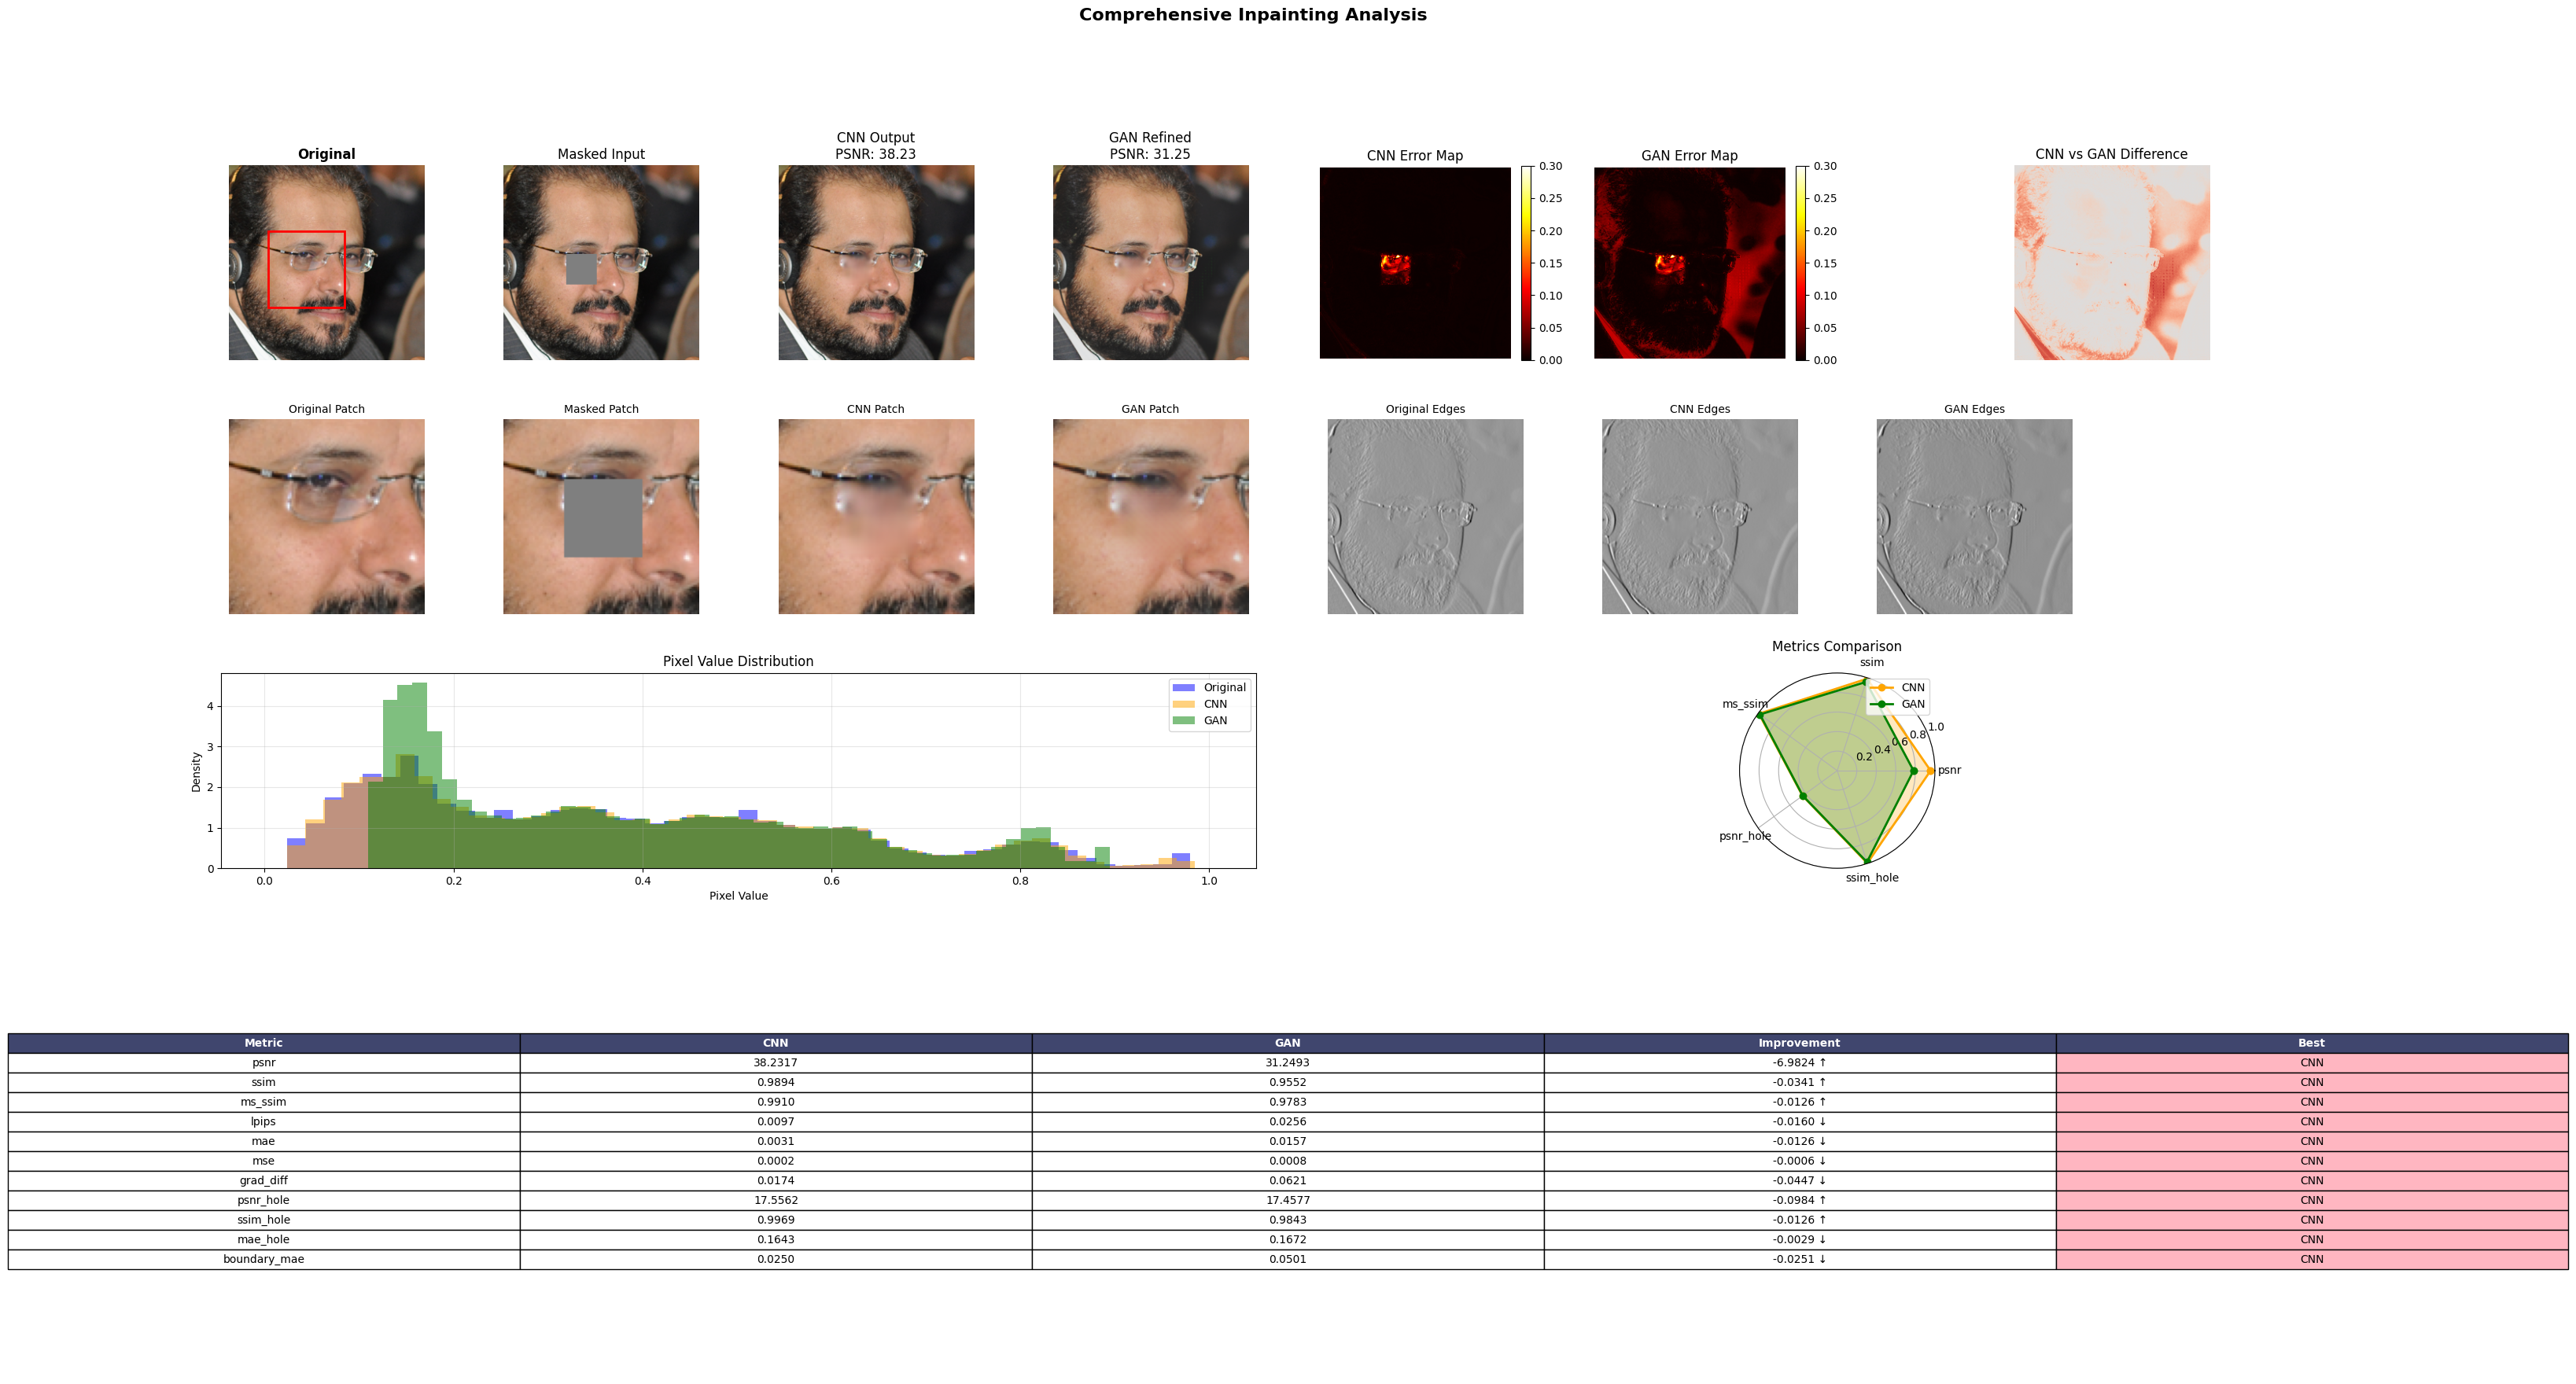

HTML report saved to evaluation_report.html


In [47]:
# Initialize comprehensive metrics
metrics_calculator = ComprehensiveMetrics(device='cuda')

# Run statistical evaluation
results = evaluate_with_statistics(cnn_model, generator, test_dataloader, num_samples=200)

# Create advanced visualization for a sample
sample_batch = next(iter(test_dataloader))
sample_image = sample_batch[0:1].to('cuda')
masked, mask = create_mask(sample_image, mask_percentage=0.025)

with torch.no_grad():
    cnn_input = torch.cat([masked, mask[:, 0:1]], dim=1)
    cnn_output = cnn_model(cnn_input)
    gan_output = generator(cnn_output, masked, mask[:, 0:1])

    metrics_cnn = metrics_calculator.calculate_all_metrics(cnn_output, sample_image, mask)
    metrics_gan = metrics_calculator.calculate_all_metrics(gan_output, sample_image, mask)

# Create visualization
create_advanced_visualization(
    sample_image[0], masked[0], cnn_output[0], gan_output[0], mask,
    metrics_cnn, metrics_gan, save_path='advanced_analysis.png'
)

# Generate HTML report
create_html_report(results, save_path='evaluation_report.html')

# Robustness to different mask scales (CNN)

In [41]:
def create_variable_mask(images, mask_percentage):
    """
    Create masks with specified percentage of image area
    Args:
        images: [B, C, H, W] tensor
        mask_percentage: float between 0 and 1 (e.g., 0.025 for 2.5%)
    """
    batch_size, _, height, width = images.shape
    masks = torch.ones_like(images)

    for i in range(batch_size):
        # Calculate mask size
        total_pixels = height * width
        mask_pixels = int(total_pixels * mask_percentage)

        # Create random mask (you can also use square/irregular masks)
        if mask_percentage < 0.1:  # For small masks, use squares
            # Square mask
            mask_size = int(np.sqrt(mask_pixels))
            top = np.random.randint(0, height - mask_size)
            left = np.random.randint(0, width - mask_size)
            masks[i, :, top:top+mask_size, left:left+mask_size] = 0
        else:  # For larger masks, use irregular shapes
            # Multiple rectangles for more realistic patterns
            num_rects = np.random.randint(1, 5)
            pixels_per_rect = mask_pixels // num_rects

            for _ in range(num_rects):
                rect_h = np.random.randint(int(np.sqrt(pixels_per_rect)//2),
                                          min(int(np.sqrt(pixels_per_rect)*2), height//2))
                rect_w = pixels_per_rect // rect_h

                if rect_h < height and rect_w < width:
                    top = np.random.randint(0, max(1, height - rect_h))
                    left = np.random.randint(0, max(1, width - rect_w))
                    masks[i, :, top:min(top+rect_h, height), left:min(left+rect_w, width)] = 0

    masked_images = images * masks
    return masked_images, masks

def evaluate_cnn_multiple_masks(cnn_model, test_loader, mask_percentages, device='cuda', num_batches=None):
    """
    Evaluate CNN performance with different mask sizes

    Args:
        cnn_model: Your trained CNN model
        test_loader: DataLoader with test images
        mask_percentages: List of mask percentages to test (e.g., [0.025, 0.05, 0.1, 0.2, 0.4])
        device: cuda or cpu
        num_batches: Number of batches to evaluate (None for all)
    """

    cnn_model.eval()
    results = {pct: {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [],
                     'psnr_hole': [], 'mae_hole': []}
               for pct in mask_percentages}

    # Initialize metrics
    psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(device)
    ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(device)
    lpips_metric = lpips.LPIPS(net='alex').to(device)

    print("Evaluating CNN with varying mask sizes...")
    print("=" * 60)

    for mask_pct in mask_percentages:
        print(f"\nTesting with {mask_pct*100:.1f}% mask...")

        batch_count = 0
        for batch_idx, batch in enumerate(tqdm(test_loader, desc=f"Mask {mask_pct*100:.1f}%")):
            if num_batches and batch_idx >= num_batches:
                break

            original_images = batch.to(device)

            with torch.no_grad():
                # Create masks with current percentage
                masked_images, masks = create_variable_mask(original_images, mask_pct)
                masks = masks.to(device)

                # CNN inference
                cnn_input = torch.cat([masked_images, masks[:, 0:1]], dim=1)
                cnn_output = cnn_model(cnn_input)

                # Ensure output is in proper range
                cnn_output = torch.clamp(cnn_output, -1, 1)

                # Convert to [0, 1] for metrics
                original_01 = (original_images + 1) / 2
                output_01 = (cnn_output + 1) / 2

                # === WHOLE IMAGE METRICS ===
                results[mask_pct]['psnr'].append(psnr_metric(output_01, original_01).item())
                results[mask_pct]['ssim'].append(ssim_metric(output_01, original_01).item())
                results[mask_pct]['lpips'].append(lpips_metric(cnn_output, original_images).mean().item())
                results[mask_pct]['mae'].append(F.l1_loss(output_01, original_01).item())

                # === HOLE-ONLY METRICS ===
                hole_mask = 1 - masks[:, 0:1]
                if hole_mask.sum() > 0:
                    # PSNR for inpainted region only
                    mse_hole = ((output_01 * hole_mask - original_01 * hole_mask) ** 2).sum() / hole_mask.sum()
                    psnr_hole = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(mse_hole)
                    results[mask_pct]['psnr_hole'].append(psnr_hole.item())

                    # MAE for inpainted region only
                    mae_hole = (F.l1_loss(output_01 * hole_mask, original_01 * hole_mask, reduction='sum') / hole_mask.sum()).item()
                    results[mask_pct]['mae_hole'].append(mae_hole)
                else:
                    results[mask_pct]['psnr_hole'].append(results[mask_pct]['psnr'][-1])
                    results[mask_pct]['mae_hole'].append(results[mask_pct]['mae'][-1])

            batch_count += 1

    return results

def print_results_table(results):
    """Print results in a nice table format"""

    print("\n" + "=" * 80)
    print("CNN PERFORMANCE VS MASK SIZE - WHOLE IMAGE METRICS")
    print("=" * 80)

    # Prepare data for whole image metrics
    data_whole = []
    for mask_pct, metrics in results.items():
        data_whole.append({
            'Mask %': f"{mask_pct*100:.1f}%",
            'PSNR ↑': f"{np.mean(metrics['psnr']):.2f} ± {np.std(metrics['psnr']):.2f}",
            'SSIM ↑': f"{np.mean(metrics['ssim']):.4f} ± {np.std(metrics['ssim']):.4f}",
            'LPIPS ↓': f"{np.mean(metrics['lpips']):.4f} ± {np.std(metrics['lpips']):.4f}",
            'MAE ↓': f"{np.mean(metrics['mae']):.4f} ± {np.std(metrics['mae']):.4f}",
        })

    df_whole = pd.DataFrame(data_whole)
    print(df_whole.to_string(index=False))

    print("\n" + "=" * 80)
    print("CNN PERFORMANCE VS MASK SIZE - INPAINTED REGION ONLY")
    print("=" * 80)

    # Prepare data for hole metrics
    data_hole = []
    for mask_pct, metrics in results.items():
        data_hole.append({
            'Mask %': f"{mask_pct*100:.1f}%",
            'PSNR (hole) ↑': f"{np.mean(metrics['psnr_hole']):.2f} ± {np.std(metrics['psnr_hole']):.2f}",
            'MAE (hole) ↓': f"{np.mean(metrics['mae_hole']):.4f} ± {np.std(metrics['mae_hole']):.4f}",
        })

    df_hole = pd.DataFrame(data_hole)
    print(df_hole.to_string(index=False))

def create_performance_plots(results, save_path='cnn_mask_performance.png'):
    """Create visualization of performance vs mask size"""

    mask_sizes = sorted(results.keys())
    mask_percentages = [m * 100 for m in mask_sizes]

    # Extract mean values
    psnr_means = [np.mean(results[m]['psnr']) for m in mask_sizes]
    psnr_stds = [np.std(results[m]['psnr']) for m in mask_sizes]

    ssim_means = [np.mean(results[m]['ssim']) for m in mask_sizes]
    ssim_stds = [np.std(results[m]['ssim']) for m in mask_sizes]

    lpips_means = [np.mean(results[m]['lpips']) for m in mask_sizes]
    lpips_stds = [np.std(results[m]['lpips']) for m in mask_sizes]

    psnr_hole_means = [np.mean(results[m]['psnr_hole']) for m in mask_sizes]
    psnr_hole_stds = [np.std(results[m]['psnr_hole']) for m in mask_sizes]

    # Create plots
    fig, axes = plt.subplots(2, 2, figsize=(12, 10))

    # PSNR vs Mask Size
    axes[0, 0].errorbar(mask_percentages, psnr_means, yerr=psnr_stds,
                       marker='o', capsize=5, capthick=2, linewidth=2)
    axes[0, 0].set_xlabel('Mask Size (%)')
    axes[0, 0].set_ylabel('PSNR (dB)')
    axes[0, 0].set_title('PSNR vs Mask Size (Whole Image)')
    axes[0, 0].grid(True, alpha=0.3)

    # SSIM vs Mask Size
    axes[0, 1].errorbar(mask_percentages, ssim_means, yerr=ssim_stds,
                       marker='s', capsize=5, capthick=2, linewidth=2, color='green')
    axes[0, 1].set_xlabel('Mask Size (%)')
    axes[0, 1].set_ylabel('SSIM')
    axes[0, 1].set_title('SSIM vs Mask Size (Whole Image)')
    axes[0, 1].grid(True, alpha=0.3)

    # LPIPS vs Mask Size
    axes[1, 0].errorbar(mask_percentages, lpips_means, yerr=lpips_stds,
                       marker='^', capsize=5, capthick=2, linewidth=2, color='red')
    axes[1, 0].set_xlabel('Mask Size (%)')
    axes[1, 0].set_ylabel('LPIPS (lower is better)')
    axes[1, 0].set_title('LPIPS vs Mask Size')
    axes[1, 0].grid(True, alpha=0.3)

    # PSNR Hole vs Mask Size
    axes[1, 1].errorbar(mask_percentages, psnr_hole_means, yerr=psnr_hole_stds,
                       marker='d', capsize=5, capthick=2, linewidth=2, color='purple')
    axes[1, 1].set_xlabel('Mask Size (%)')
    axes[1, 1].set_ylabel('PSNR (dB)')
    axes[1, 1].set_title('PSNR vs Mask Size (Inpainted Region Only)')
    axes[1, 1].grid(True, alpha=0.3)

    plt.suptitle('CNN Inpainting Performance vs Mask Size', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"\nPlots saved to {save_path}")

def create_visual_comparison(cnn_model, test_loader, mask_percentages, device='cuda',
                            save_path='mask_size_visual_comparison.png'):
    """Create visual comparison showing results with different mask sizes"""

    # Get one sample image
    sample_batch = next(iter(test_loader))
    sample_image = sample_batch[0:1].to(device)

    fig, axes = plt.subplots(3, len(mask_percentages), figsize=(4*len(mask_percentages), 12))

    cnn_model.eval()

    with torch.no_grad():
        for idx, mask_pct in enumerate(mask_percentages):
            # Create mask
            masked_image, mask = create_variable_mask(sample_image, mask_pct)
            mask = mask.to(device)

            # CNN inference
            cnn_input = torch.cat([masked_image, mask[:, 0:1]], dim=1)
            cnn_output = cnn_model(cnn_input)

            # Convert to displayable format
            def to_img(tensor):
                return ((tensor[0].cpu() + 1) / 2).clamp(0, 1).permute(1, 2, 0)

            # Row 1: Masked input
            axes[0, idx].imshow(to_img(masked_image))
            axes[0, idx].set_title(f'Masked ({mask_pct*100:.1f}%)')
            axes[0, idx].axis('off')

            # Row 2: CNN output
            axes[1, idx].imshow(to_img(cnn_output))
            axes[1, idx].set_title('CNN Output')
            axes[1, idx].axis('off')

            # Row 3: Error map
            error = torch.abs(cnn_output - sample_image).mean(dim=1, keepdim=True)
            axes[2, idx].imshow(error[0, 0].cpu(), cmap='hot', vmin=0, vmax=0.5)
            axes[2, idx].set_title('Error Map')
            axes[2, idx].axis('off')

    # Add row labels
    axes[0, 0].set_ylabel('Masked Input', fontsize=12, fontweight='bold')
    axes[1, 0].set_ylabel('CNN Output', fontsize=12, fontweight='bold')
    axes[2, 0].set_ylabel('Error Map', fontsize=12, fontweight='bold')

    plt.suptitle('CNN Performance Across Different Mask Sizes', fontsize=14, fontweight='bold')
    plt.tight_layout()
    plt.savefig(save_path, dpi=150, bbox_inches='tight')
    plt.show()

    print(f"Visual comparison saved to {save_path}")

Loading CNN model...
✅ CNN model loaded successfully
Setting up [LPIPS] perceptual loss: trunk [alex], v[0.1], spatial [off]


/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `PeakSignalNoiseRatio` from `torchmetrics` was deprecated and will be removed in 2.0. Import `PeakSignalNoiseRatio` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchmetrics/utilities/prints.py:62: FutureWarning: Importing `StructuralSimilarityIndexMeasure` from `torchmetrics` was deprecated and will be removed in 2.0. Import `StructuralSimilarityIndexMeasure` from `torchmetrics.image` instead.
  _future_warning(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The cu

Loading model from: /usr/local/lib/python3.11/dist-packages/lpips/weights/v0.1/alex.pth
Evaluating CNN with varying mask sizes...

Testing with 2.5% mask...


Mask 2.5%:   0%|          | 0/250 [00:00<?, ?it/s]


Testing with 5.0% mask...


Mask 5.0%:   0%|          | 0/250 [00:00<?, ?it/s]


Testing with 10.0% mask...


Mask 10.0%:   0%|          | 0/250 [00:00<?, ?it/s]


Testing with 20.0% mask...


Mask 20.0%:   0%|          | 0/250 [00:00<?, ?it/s]


CNN PERFORMANCE VS MASK SIZE - WHOLE IMAGE METRICS
Mask %       PSNR ↑          SSIM ↑         LPIPS ↓           MAE ↓
  2.5% 36.43 ± 2.27 0.9868 ± 0.0039 0.0123 ± 0.0032 0.0039 ± 0.0006
  5.0% 30.98 ± 1.51 0.9745 ± 0.0049 0.0284 ± 0.0045 0.0068 ± 0.0009
 10.0% 28.32 ± 1.48 0.9547 ± 0.0061 0.0509 ± 0.0068 0.0106 ± 0.0016
 20.0% 23.44 ± 1.24 0.9058 ± 0.0099 0.1149 ± 0.0124 0.0235 ± 0.0036

CNN PERFORMANCE VS MASK SIZE - INPAINTED REGION ONLY
Mask % PSNR (hole) ↑    MAE (hole) ↓
  2.5%  15.83 ± 2.39 0.1933 ± 0.0498
  5.0%  13.24 ± 1.54 0.2726 ± 0.0492
 10.0%  13.42 ± 1.47 0.2595 ± 0.0453
 20.0%  11.35 ± 1.21 0.3469 ± 0.0532


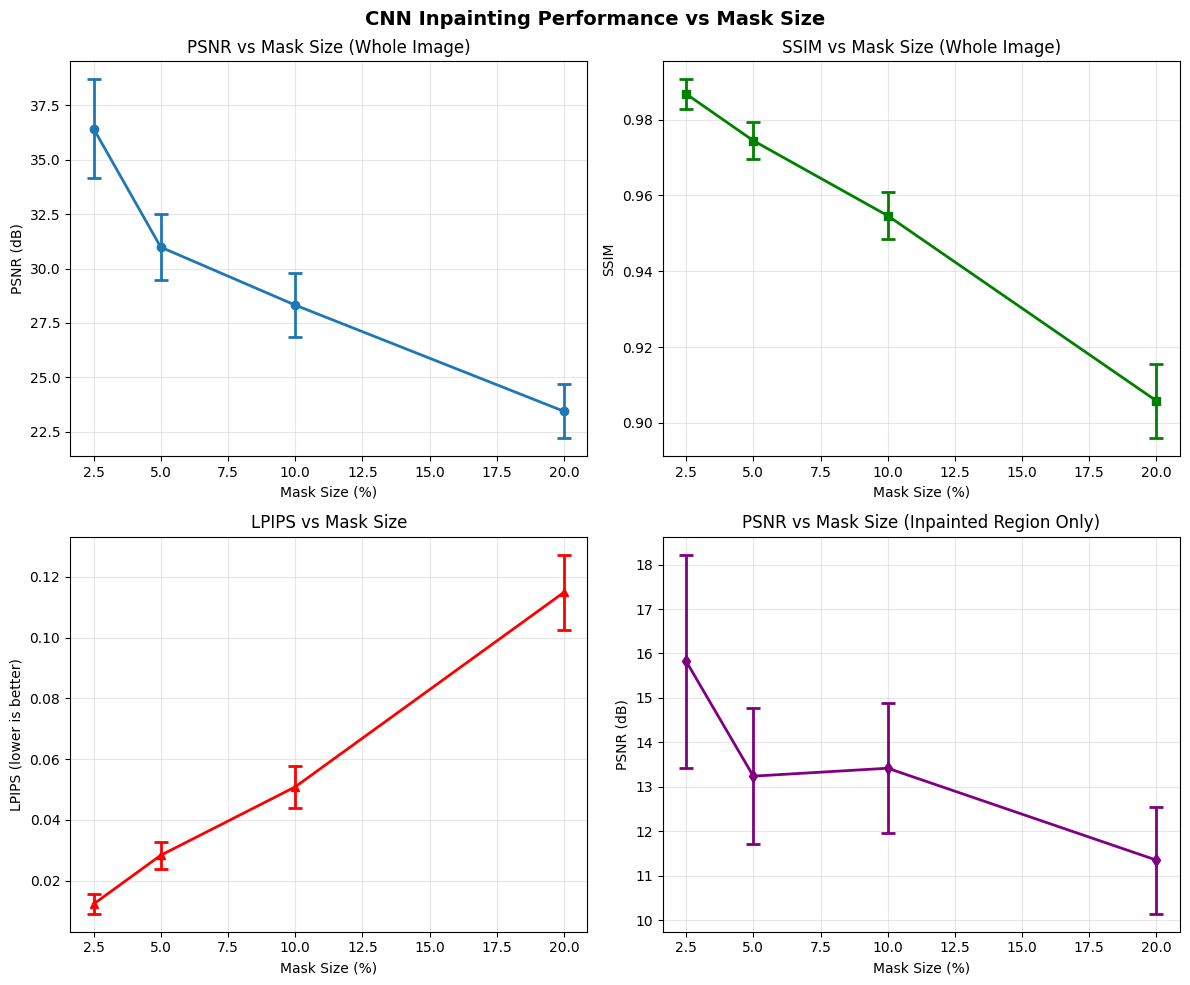


Plots saved to cnn_mask_performance.png


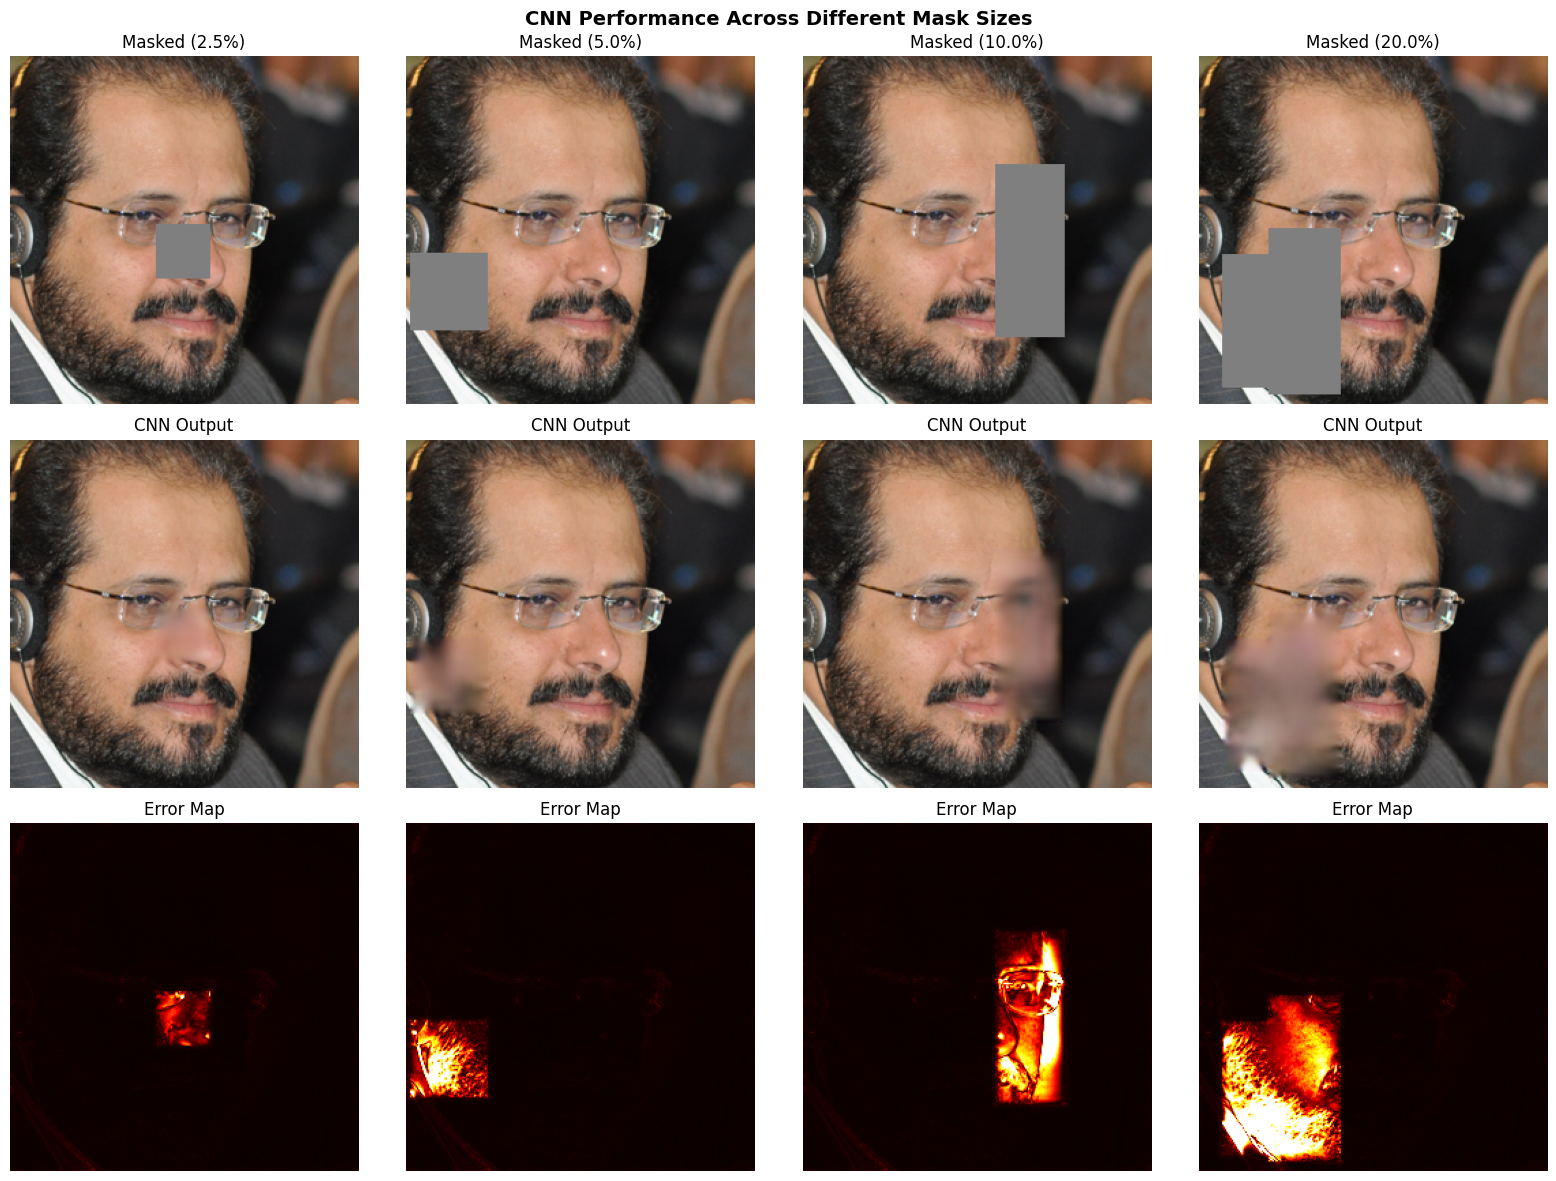

Visual comparison saved to mask_size_visual_comparison.png

Saving detailed results to CSV...
✅ Results saved to cnn_mask_evaluation_detailed.csv

EVALUATION COMPLETE
Tested mask sizes: ['2.5%', '5.0%', '10.0%', '20.0%']
Number of test batches: 250

Key Findings:
   2.5% mask → PSNR: 36.43 dB
   5.0% mask → PSNR: 30.98 dB
  10.0% mask → PSNR: 28.32 dB
  20.0% mask → PSNR: 23.44 dB


In [46]:
# ============================================
# MAIN EXECUTION
# ============================================

# Define mask percentages to test
MASK_PERCENTAGES = [0.025, 0.05, 0.1, 0.2]  # 2.5%, 5%, 10%, 20%

# Load your CNN model
print("Loading CNN model...")
cnn_model = UNetSR(in_channels=4, out_channels=3).to(DEVICE)
cnn_state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/inpainting/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)
cnn_model.eval()
print("✅ CNN model loaded successfully")

# Run evaluation
results = evaluate_cnn_multiple_masks(
    cnn_model=cnn_model,
    test_loader=test_dataloader,
    mask_percentages=MASK_PERCENTAGES,
    device=DEVICE,
    num_batches=None  # Use 50 batches for faster testing, or None for full test set
)

# Print results
print_results_table(results)

# Create performance plots
create_performance_plots(results, save_path='cnn_mask_performance.png')

# Create visual comparison
create_visual_comparison(
    cnn_model=cnn_model,
    test_loader=test_dataloader,
    mask_percentages=MASK_PERCENTAGES,
    device=DEVICE,
    save_path='mask_size_visual_comparison.png'
)

# Save results to CSV for further analysis
print("\nSaving detailed results to CSV...")
detailed_results = []
for mask_pct in MASK_PERCENTAGES:
    for i in range(len(results[mask_pct]['psnr'])):
        detailed_results.append({
            'mask_percentage': mask_pct * 100,
            'psnr': results[mask_pct]['psnr'][i],
            'ssim': results[mask_pct]['ssim'][i],
            'lpips': results[mask_pct]['lpips'][i],
            'mae': results[mask_pct]['mae'][i],
            'psnr_hole': results[mask_pct]['psnr_hole'][i],
            'mae_hole': results[mask_pct]['mae_hole'][i],
        })

df_detailed = pd.DataFrame(detailed_results)
df_detailed.to_csv('cnn_mask_evaluation_detailed.csv', index=False)
print("✅ Results saved to cnn_mask_evaluation_detailed.csv")

# Print summary
print("\n" + "="*60)
print("EVALUATION COMPLETE")
print("="*60)
print(f"Tested mask sizes: {[f'{m*100:.1f}%' for m in MASK_PERCENTAGES]}")
print(f"Number of test batches: {len(results[MASK_PERCENTAGES[0]]['psnr'])}")
print("\nKey Findings:")
for mask_pct in MASK_PERCENTAGES:
    psnr_mean = np.mean(results[mask_pct]['psnr'])
    print(f"  {mask_pct*100:4.1f}% mask → PSNR: {psnr_mean:.2f} dB")

# Archive

In [ ]:
def sample_diffusion(diffusion_model, coarse_inpainting, original_image, mask, num_timesteps, device):
    """
    Sample residuals following ResDiff approach
    """
    betas = torch.linspace(0.0001, 0.02, num_timesteps, device=device)
    alphas = 1. - betas
    alphas_cumprod = torch.cumprod(alphas, dim=0)

    # Precompute variance schedule (following DDPM paper)
    alphas_cumprod_prev = torch.cat([torch.ones(1, device=device), alphas_cumprod[:-1]])

    # Start with pure noise (this will become the denoised residual)
    x_t = torch.randn_like(original_image, device=device)

    # Reverse diffusion process
    for t in reversed(range(num_timesteps)):
        time = torch.full((original_image.shape[0],), t, device=device, dtype=torch.long)

        with torch.no_grad():
            # Model predicts noise from noisy residual
            pred_noise = diffusion_model(x_t, time, coarse_inpainting, mask)

        # Get coefficients
        alpha_t = alphas[t]
        alpha_t_cumprod = alphas_cumprod[t]
        alpha_t_cumprod_prev = alphas_cumprod_prev[t]

        # Compute x_0 prediction (optional but can improve stability)
        x_0_pred = (x_t - torch.sqrt(1 - alpha_t_cumprod) * pred_noise) / torch.sqrt(alpha_t_cumprod)
        x_0_pred = torch.clamp(x_0_pred, -1, 1)  # Clip prediction

        # Standard DDPM denoising step
        coeff1 = 1 / torch.sqrt(alpha_t)
        coeff2 = (1 - alpha_t) / torch.sqrt(1 - alpha_t_cumprod)

        mean = coeff1 * (x_t - coeff2 * pred_noise)

        if t > 0:
            # Use the "fixed large" variance from DDPM paper
            variance = betas[t] * (1 - alpha_t_cumprod_prev) / (1 - alpha_t_cumprod)
            sigma_t = torch.sqrt(variance)
            noise = torch.randn_like(x_t)
            x_t = mean + sigma_t * noise
        else:
            x_t = mean

    # x_t is now the denoised residual
    # Add to CNN prediction (as per ResDiff Algorithm 1, line 7)
    final_image = coarse_inpainting + x_t

    # CRITICAL: Preserve unmasked regions exactly
    final_image = final_image * (1 - mask) + original_image * mask

    # Clamp to valid range
    final_image = torch.clamp(final_image, -1, 1)

    return final_image

In [ ]:
# Helper module for sinusoidal time embeddings
class SinusoidalPositionEmbeddings(nn.Module):
    def __init__(self, dim):
        super().__init__()
        self.dim = dim

    def forward(self, time):
        device = time.device
        half_dim = self.dim // 2
        embeddings = math.log(10000) / (half_dim - 1)
        embeddings = torch.exp(torch.arange(half_dim, device=device) * -embeddings)
        embeddings = time[:, None] * embeddings[None, :]
        embeddings = torch.cat((embeddings.sin(), embeddings.cos()), dim=-1)
        return embeddings

# --- Squeeze-and-Excitation Block ---
# A helper module required by the FD Info Splitter
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=8):
        super().__init__()
        # Ensure the bottleneck dimension is at least 1 to avoid a zero-element tensor
        bottleneck_channels = max(1, channels // reduction)

        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channels, bottleneck_channels, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(bottleneck_channels, channels, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.shape
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

# --- FD Info Splitter Module ---
class FDInfoSplitter(nn.Module):
    def __init__(self, channels):
        super().__init__()
        # SE block for the low-frequency path's attention weights
        self.se_lf = SEBlock(channels)
        # SE block to predict sigma for the adaptive filter
        self.sigma_se = SEBlock(channels)

    def forward(self, x_cnn):
        b, c, h, w = x_cnn.shape
        M = torch.fft.fft2(x_cnn, dim=(-2, -1))

        # --- High-Frequency Path with Adaptive Filter ---
        sigma_features = self.sigma_se(M.abs())
        sigma_features = sigma_features.view(b, c, -1).mean(dim=[1, 2])
        l = min(h, w)
        sigma = torch.clamp(sigma_features.abs() + l / 2, max=l)
        sigma = sigma.view(b, 1, 1, 1)
        center_h, center_w = h // 2, w // 2
        Y, X = torch.meshgrid(
            torch.arange(h, device=x_cnn.device),
            torch.arange(w, device=x_cnn.device),
            indexing='ij'
        )
        D_sq = (Y - center_h)**2 + (X - center_w)**2
        hp_mask = 1 - torch.exp(-D_sq / (2 * sigma**2))
        hp_mask_shifted = torch.fft.ifftshift(hp_mask, dim=(-2, -1))
        M_prime = M * hp_mask_shifted
        x_hf = torch.fft.ifft2(M_prime, dim=(-2, -1)).real

        # --- 🎯 UPDATED: Low-Frequency Path with Frequency-Based Attention ---
        # As per the paper (Eq. 10), learn attention weights from the frequency map M
        # and apply them to the spatial image x_cnn.
        # We apply the SE block to the magnitude of the complex frequency map.
        freq_attention_weights = self.se_lf(M.abs())
        x_lf = x_cnn * freq_attention_weights

        return x_hf, x_lf

class HFAttention(nn.Module):
    def __init__(self, encoder_channels, dwt_channels):
        super().__init__()
        self.q_proj = nn.Conv2d(dwt_channels, encoder_channels, 1)
        self.k_proj = nn.Conv2d(encoder_channels, encoder_channels, 1)
        self.v_proj = nn.Conv2d(encoder_channels, encoder_channels, 1)
        self.out_proj = nn.Conv2d(encoder_channels, encoder_channels, 1)

    def forward(self, encoder_features, dwt_hf_features):
        # Debug prints
        # print(f"Encoder features shape: {encoder_features.shape}")
        # print(f"DWT features shape: {dwt_hf_features.shape}")

        # Get dimensions from encoder features
        b, c, h, w = encoder_features.shape

        # Ensure DWT features have same batch size and spatial dims
        if dwt_hf_features.shape[0] != b:
            # This shouldn't happen, but let's handle it
            dwt_hf_features = dwt_hf_features[:b]  # Trim to match batch size

        # Resize to match spatial dimensions
        dwt_hf_features = F.interpolate(
            dwt_hf_features,
            size=(h, w),
            mode='bilinear',
            align_corners=False
        )

        # Project
        q = self.q_proj(dwt_hf_features)
        k = self.k_proj(encoder_features)
        v = self.v_proj(encoder_features)

        # Reshape using consistent dimensions
        hw = h * w
        q = q.reshape(b, c, hw).permute(0, 2, 1)
        k = k.reshape(b, c, hw)
        v = v.reshape(b, c, hw).permute(0, 2, 1)

        # Attention
        attn_weights = F.softmax(torch.bmm(q, k) / (c ** 0.5), dim=-1)
        attended_features = torch.bmm(attn_weights, v).permute(0, 2, 1)

        # Reshape back
        attended_features = attended_features.reshape(b, c, h, w)

        return self.out_proj(attended_features)


# --- NEW: Adaptive Denoising Module ---
class AdaptiveDenoising(nn.Module):
    def __init__(self, time_channels, img_channels):
        super().__init__()
        # A simple MLP to process the time embedding
        self.time_proj = nn.Sequential(
            nn.SiLU(),
            nn.Linear(time_channels, img_channels * 2)
        )

    def forward(self, noisy_image, time_embedding):
        # Project time embedding to get scale and shift parameters
        params = self.time_proj(time_embedding)
        # Reshape for broadcasting
        params = params[:, :, None, None]
        scale, shift = params.chunk(2, dim=1)

        # Apply adaptive instance normalization
        return noisy_image * (scale + 1) + shift

class DiffusionUNet(nn.Module):
    def __init__(self, in_channels=3, model_channels=64, time_emb_dim=256):
        super().__init__()
        self.dwt = DWTForward(J=2, mode='zero', wave='haar')
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(time_emb_dim),
            nn.Linear(time_emb_dim, model_channels),
            nn.ReLU()
        )
        self.fd_splitter = FDInfoSplitter(in_channels)
        self.adaptive_denoiser = AdaptiveDenoising(model_channels, in_channels)

        self.init_conv = nn.Conv2d(in_channels * 5 + 1, model_channels, 3, padding=1)

        self.down1 = nn.Sequential(nn.Conv2d(model_channels, model_channels * 2, 4, 2, 1), nn.ReLU())
        self.down2 = nn.Sequential(nn.Conv2d(model_channels * 2, model_channels * 4, 4, 2, 1), nn.ReLU())

        self.bot1 = nn.Conv2d(model_channels * 4, model_channels * 4, 3, padding=1)
        self.bot2 = nn.Conv2d(model_channels * 4, model_channels * 4, 3, padding=1)

        self.attn1 = HFAttention(encoder_channels=model_channels * 2, dwt_channels=in_channels)
        self.attn2 = HFAttention(encoder_channels=model_channels * 4, dwt_channels=in_channels)

        self.up1 = nn.ConvTranspose2d(model_channels * 8, model_channels * 2, 4, 2, 1)
        self.up2 = nn.ConvTranspose2d(model_channels * 4, model_channels, 4, 2, 1)

        self.out_conv = nn.Conv2d(model_channels * 2, in_channels, 3, padding=1)

    def forward(self, noisy_image, time, cnn_prediction, mask):
        time_embedding = self.time_mlp(time)
        x_hf, x_lf = self.fd_splitter(cnn_prediction)
        denoised_image = self.adaptive_denoiser(noisy_image, time_embedding)

        # ✅ DWT handling is correct now!
        _, hf_coeffs = self.dwt(cnn_prediction)
        hf_level1 = hf_coeffs[0][0] + hf_coeffs[0][1] + hf_coeffs[0][2]
        hf_level2 = hf_coeffs[1][0] + hf_coeffs[1][1] + hf_coeffs[1][2]

        x_init = torch.cat([noisy_image, denoised_image, cnn_prediction, x_hf, x_lf, mask[:, 0:1, :, :]], dim=1)
        x = self.init_conv(x_init)

        # Encoder
        x1 = self.down1(x)
        x2 = self.down2(x1)

        # Bottleneck
        x_bot = F.relu(self.bot1(x2))
        x_bot = self.bot2(x_bot)
        x_bot = F.relu(x_bot + x2)

        # Decoder with skip connections
        attn2_out = self.attn2(x2, hf_level2)
        # 🔧 FIX: Include skip connection from x2
        up1_in = torch.cat([x_bot, x2 + attn2_out], dim=1)  # Restored!
        up1_out = self.up1(up1_in)

        attn1_out = self.attn1(x1, hf_level1)
        # 🔧 FIX: Include skip connection from x1
        up2_in = torch.cat([up1_out, x1 + attn1_out], dim=1)  # Restored!
        up2_out = self.up2(up2_in)

        out_in = torch.cat([up2_out, x], dim=1)
        return self.out_conv(out_in)

In [ ]:
torch._dynamo.reset()  # Reset any compilation state

# Load CNN with EXACT same initialization as training
cnn_model = UNetSR().to(DEVICE)  # No parameters!

# Load weights
cnn_state_dict = torch.load('/content/drive/MyDrive/ColabNotebooks/Vision/diffusionProject/final_cnn_model.pth', map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)

# Freeze
cnn_model.eval()
for param in cnn_model.parameters():
    param.requires_grad = False

# Initialize diffusion WITHOUT compilation
diffusion_model = DiffusionUNet(
    in_channels=3,
    model_channels=32,
    time_emb_dim=128
).to(DEVICE)

# Initialize optimizer
optimizer_diffusion = torch.optim.Adam(diffusion_model.parameters(), lr=1e-5)

print("✅ Models loaded successfully without compilation issues")

# --- Stage 2: Train the Diffusion Model (ResDiff-style) ---
print("\n--- Stage 2: Training Diffusion Model ---")
num_timesteps = 2000
betas = torch.linspace(0.0001, 0.02, num_timesteps).to(DEVICE)
alphas = 1. - betas
alphas_cumprod = torch.cumprod(alphas, axis=0)

# --- GRADIENT ACCUMULATION SETUP ---
EFFECTIVE_BATCH_SIZE = 32
accumulation_steps = EFFECTIVE_BATCH_SIZE // BATCH_SIZE

scaler = torch.amp.GradScaler(DEVICE)
optimizer_diffusion.zero_grad()

# Add learning rate scheduler
scheduler_diffusion = torch.optim.lr_scheduler.CosineAnnealingLR(
    optimizer_diffusion,
    T_max=NUM_EPOCHS_DIFFUSION
)

# Training monitoring
best_val_loss = float('inf')
train_losses = []

for epoch in tqdm(range(NUM_EPOCHS_DIFFUSION), desc="Diffusion Epochs"):
    epoch_losses = []

    for i, batch in enumerate(diffusion_dataloader):
        original_image = batch.to(DEVICE)
        masked_image, mask = create_mask(original_image)
        mask = mask.to(DEVICE)

        with torch.no_grad():
            cnn_input = torch.cat((masked_image, mask[:, 0:1, :, :]), dim=1)
            coarse_inpainting = cnn_model(cnn_input)

        # Train on residuals
        residual = original_image - coarse_inpainting

        # Sample timestep
        t = torch.randint(0, num_timesteps, (original_image.size(0),), device=DEVICE)
        noise = torch.randn_like(residual)
        alpha_t = alphas_cumprod[t].view(-1, 1, 1, 1)

        # Add noise to the residual
        noisy_residual = torch.sqrt(alpha_t) * residual + torch.sqrt(1 - alpha_t) * noise

        with torch.amp.autocast(DEVICE):
            predicted_noise = diffusion_model(noisy_residual, t, coarse_inpainting, mask)

            # Weighted loss
            HOLE_WEIGHT = 2.0
            hole_mask = 1 - mask

            loss_hole = nn.functional.mse_loss(
                predicted_noise * hole_mask,
                noise * hole_mask,
                reduction='sum'
            ) / hole_mask.sum().clamp(min=1)

            loss_valid = nn.functional.mse_loss(
                predicted_noise * mask,
                noise * mask,
                reduction='sum'
            ) / mask.sum().clamp(min=1)

            loss = (loss_valid + loss_hole * HOLE_WEIGHT) / accumulation_steps

        scaler.scale(loss).backward()
        epoch_losses.append(loss.item() * accumulation_steps)

        if (i + 1) % accumulation_steps == 0:
            # Gradient clipping for stability
            scaler.unscale_(optimizer_diffusion)
            torch.nn.utils.clip_grad_norm_(diffusion_model.parameters(), 1.0)

            scaler.step(optimizer_diffusion)
            scaler.update()
            optimizer_diffusion.zero_grad()

    # Update scheduler
    scheduler_diffusion.step()

    # Print epoch summary
    avg_loss = np.mean(epoch_losses)
    train_losses.append(avg_loss)
    print(f"\nEpoch {epoch}: Loss = {avg_loss:.4f}, LR = {scheduler_diffusion.get_last_lr()[0]:.6f}")

    # Validation and sample generation every 25 epochs
    if epoch % 25 == 0:
        print(f"Generating samples at epoch {epoch}...")
        diffusion_model.eval()

        with torch.no_grad():
            # Get a validation batch
            val_batch = next(iter(diffusion_dataloader))
            val_images = val_batch[:4].to(DEVICE)  # Use 4 images
            val_masked, val_masks = create_mask(val_images)
            val_masks = val_masks.to(DEVICE)

            # Get CNN predictions
            val_cnn_input = torch.cat((val_masked, val_masks[:, 0:1, :, :]), dim=1)
            val_coarse = cnn_model(val_cnn_input)

            # Sample from diffusion
            val_samples = sample_diffusion(
                diffusion_model,
                val_coarse,
                val_images,
                val_masks,
                num_timesteps=1000,
                device=DEVICE
            )

            # Save samples
            comparison = torch.cat([
                (val_images + 1) / 2,      # Original
                (val_masked + 1) / 2,      # Masked
                (val_coarse + 1) / 2,      # CNN output
                (val_samples + 1) / 2      # Diffusion output
            ], dim=0)

            save_image(comparison, f'diffusion_samples_epoch_{epoch}.png', nrow=4)
            print(f"✅ Samples saved to 'diffusion_samples_epoch_{epoch}.png'")

        diffusion_model.train()

    # Save checkpoint every 20 epochs
    if epoch % 20 == 0 and epoch > 0:
        checkpoint = {
            'epoch': epoch,
            'model_state_dict': diffusion_model.state_dict(),
            'optimizer_state_dict': optimizer_diffusion.state_dict(),
            'scheduler_state_dict': scheduler_diffusion.state_dict(),
            'loss': avg_loss,
        }
        torch.save(checkpoint, f'diffusion_checkpoint_epoch_{epoch}.pth')

print("✅ Diffusion Model Training Complete.")
torch.save(diffusion_model.state_dict(), 'diffusion_model_weights.pth')

# Plot training curve
plt.figure(figsize=(10, 6))
plt.plot(train_losses)
plt.title('Diffusion Model Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.grid(True)
plt.savefig('diffusion_training_curve.png')
plt.show()

In [ ]:
# --- Final Inference and Visualization with Comprehensive Metrics ---

# Try to import lpips
try:
    import lpips
    lpips_available = True
except:
    print("LPIPS not available. Install with: pip install lpips")
    lpips_available = False

# 1. Initialize your models
print("Initializing models...")
cnn_model = UNetSR(in_channels=4, out_channels=3).to(DEVICE)
diffusion_model = DiffusionUNet(
    in_channels=3,
    model_channels=32,
    time_emb_dim=128
).to(DEVICE)

# --- LOAD WEIGHTS ---
CNN_WEIGHTS_PATH = 'cnn_model_weights.pth'
DIFFUSION_WEIGHTS_PATH = 'diffusion_model_weights.pth'

print(f"Loading weights...")
# Load CNN
cnn_state_dict = torch.load(CNN_WEIGHTS_PATH, map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in cnn_state_dict.keys()):
    cnn_state_dict = {k.replace('_orig_mod.', ''): v for k, v in cnn_state_dict.items()}
cnn_model.load_state_dict(cnn_state_dict)

# Load Diffusion
diffusion_state_dict = torch.load(DIFFUSION_WEIGHTS_PATH, map_location=DEVICE)
if any(k.startswith('_orig_mod.') for k in diffusion_state_dict.keys()):
    diffusion_state_dict = {k.replace('_orig_mod.', ''): v for k, v in diffusion_state_dict.items()}
diffusion_model.load_state_dict(diffusion_state_dict)

print("✅ All weights loaded successfully.")

# 2. Set models to evaluation mode
cnn_model.eval()
diffusion_model.eval()

# --- Initialize Metrics ---
psnr_metric = torchmetrics.PeakSignalNoiseRatio(data_range=1.0).to(DEVICE)
ssim_metric = torchmetrics.StructuralSimilarityIndexMeasure(data_range=1.0).to(DEVICE)
if lpips_available:
    lpips_metric = lpips.LPIPS(net='alex').to(DEVICE)

# --- Evaluate on Multiple Batches ---
print("\n📊 Evaluating on multiple batches...")
num_eval_batches = 10
all_metrics = {
    'cnn': {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [], 'time': []},
    'diffusion': {'psnr': [], 'ssim': [], 'lpips': [], 'mae': [], 'time': []}
}

eval_dataloader = DataLoader(full_dataset, batch_size=8, shuffle=False)

for batch_idx, batch in enumerate(eval_dataloader):
    if batch_idx >= num_eval_batches:
        break

    original_images = batch.to(DEVICE)

    with torch.no_grad():
        # Create masks
        masked_images, masks = create_mask(original_images, mask_percentage=0.025)
        masks = masks.to(DEVICE)

        # CNN inference with timing
        start_time = time.time()
        cnn_input = torch.cat((masked_images, masks[:, 0:1, :, :]), dim=1)
        coarse_inpainting = cnn_model(cnn_input)
        cnn_time = time.time() - start_time

        # Diffusion inference with timing
        start_time = time.time()
        final_inpainting = sample_diffusion(
            diffusion_model,
            coarse_inpainting,
            original_images,  # Pass original, not masked!
            masks,
            num_timesteps=1000,
            device=DEVICE
        )
        diffusion_time = time.time() - start_time

        # Convert to [0, 1] for metrics
        original_01 = (original_images + 1) / 2
        coarse_01 = (coarse_inpainting + 1) / 2
        final_01 = (final_inpainting + 1) / 2

        # Calculate metrics for CNN
        cnn_psnr = psnr_metric(coarse_01, original_01)
        cnn_ssim = ssim_metric(coarse_01, original_01)
        cnn_mae = F.l1_loss(coarse_01, original_01)

        all_metrics['cnn']['psnr'].append(cnn_psnr.item())
        all_metrics['cnn']['ssim'].append(cnn_ssim.item())
        all_metrics['cnn']['mae'].append(cnn_mae.item())
        all_metrics['cnn']['time'].append(cnn_time)

        if lpips_available:
            cnn_lpips = lpips_metric(coarse_01 * 2 - 1, original_01 * 2 - 1)
            all_metrics['cnn']['lpips'].append(cnn_lpips.mean().item())

        # Calculate metrics for Diffusion
        diff_psnr = psnr_metric(final_01, original_01)
        diff_ssim = ssim_metric(final_01, original_01)
        diff_mae = F.l1_loss(final_01, original_01)

        all_metrics['diffusion']['psnr'].append(diff_psnr.item())
        all_metrics['diffusion']['ssim'].append(diff_ssim.item())
        all_metrics['diffusion']['mae'].append(diff_mae.item())
        all_metrics['diffusion']['time'].append(diffusion_time)

        if lpips_available:
            diff_lpips = lpips_metric(final_01 * 2 - 1, original_01 * 2 - 1)
            all_metrics['diffusion']['lpips'].append(diff_lpips.mean().item())

# --- Print Results ---
print("\n" + "="*60)
print("INPAINTING EVALUATION RESULTS")
print("="*60)

print("\n🔷 CNN MODEL:")
print(f"  PSNR:  {np.mean(all_metrics['cnn']['psnr']):.2f} ± {np.std(all_metrics['cnn']['psnr']):.2f} dB")
print(f"  SSIM:  {np.mean(all_metrics['cnn']['ssim']):.4f} ± {np.std(all_metrics['cnn']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['cnn']['mae']):.4f} ± {np.std(all_metrics['cnn']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['cnn']['lpips']):.4f} ± {np.std(all_metrics['cnn']['lpips']):.4f}")
print(f"  Time:  {np.mean(all_metrics['cnn']['time']):.3f} ± {np.std(all_metrics['cnn']['time']):.3f} sec")

print("\n🔶 DIFFUSION MODEL (CNN + Diffusion):")
print(f"  PSNR:  {np.mean(all_metrics['diffusion']['psnr']):.2f} ± {np.std(all_metrics['diffusion']['psnr']):.2f} dB")
print(f"  SSIM:  {np.mean(all_metrics['diffusion']['ssim']):.4f} ± {np.std(all_metrics['diffusion']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['diffusion']['mae']):.4f} ± {np.std(all_metrics['diffusion']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['diffusion']['lpips']):.4f} ± {np.std(all_metrics['diffusion']['lpips']):.4f}")
print(f"  Time:  {np.mean(all_metrics['diffusion']['time']):.3f} ± {np.std(all_metrics['diffusion']['time']):.3f} sec")

print("\n📈 IMPROVEMENT (Diffusion vs CNN):")
print(f"  PSNR:  +{np.mean(all_metrics['diffusion']['psnr']) - np.mean(all_metrics['cnn']['psnr']):.2f} dB")
print(f"  SSIM:  +{np.mean(all_metrics['diffusion']['ssim']) - np.mean(all_metrics['cnn']['ssim']):.4f}")
print(f"  MAE:   {np.mean(all_metrics['diffusion']['mae']) - np.mean(all_metrics['cnn']['mae']):.4f}")
if lpips_available:
    print(f"  LPIPS: {np.mean(all_metrics['diffusion']['lpips']) - np.mean(all_metrics['cnn']['lpips']):.4f}")

# --- Enhanced Visualization ---
print("\n🎨 Generating visualization...")

# Get a fresh batch for visualization
vis_batch = next(iter(eval_dataloader))
vis_images = vis_batch[:6].to(DEVICE)  # Show 6 examples

with torch.no_grad():
    vis_masked, vis_masks = create_mask(vis_images, mask_percentage=0.025)
    vis_masks = vis_masks.to(DEVICE)

    vis_cnn_input = torch.cat((vis_masked, vis_masks[:, 0:1, :, :]), dim=1)
    vis_coarse = cnn_model(vis_cnn_input)

    vis_final = sample_diffusion(
        diffusion_model,
        vis_coarse,
        vis_images,
        vis_masks,
        num_timesteps=1000,
        device=DEVICE
    )

# Create comprehensive visualization
fig = plt.figure(figsize=(20, 18))
fig.suptitle('ResDiff Inpainting Results', fontsize=20, y=0.98)

num_examples = 6
for i in range(num_examples):
    # Original
    plt.subplot(num_examples, 6, i*6 + 1)
    plt.imshow(tensor_to_image(vis_images[i]))
    plt.title("Original", fontsize=12)
    plt.axis('off')

    # Masked
    plt.subplot(num_examples, 6, i*6 + 2)
    plt.imshow(tensor_to_image(vis_masked[i]))
    plt.title("Masked Input", fontsize=12)
    plt.axis('off')

    # CNN Output
    plt.subplot(num_examples, 6, i*6 + 3)
    plt.imshow(tensor_to_image(vis_coarse[i]))
    # Calculate PSNR for this image
    img_psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(
        F.mse_loss((vis_coarse[i] + 1) / 2, (vis_images[i] + 1) / 2)
    )
    plt.title(f"CNN (PSNR: {img_psnr:.1f})", fontsize=12)
    plt.axis('off')

    # Diffusion Output
    plt.subplot(num_examples, 6, i*6 + 4)
    plt.imshow(tensor_to_image(vis_final[i]))
    # Calculate PSNR for this image
    img_psnr = 20 * torch.log10(torch.tensor(1.0)) - 10 * torch.log10(
        F.mse_loss((vis_final[i] + 1) / 2, (vis_images[i] + 1) / 2)
    )
    plt.title(f"Diffusion (PSNR: {img_psnr:.1f})", fontsize=12)
    plt.axis('off')

    # Difference Map (CNN)
    diff_cnn = torch.abs(vis_images[i] - vis_coarse[i]).mean(dim=0)
    plt.subplot(num_examples, 6, i*6 + 5)
    im = plt.imshow(diff_cnn.cpu().numpy(), cmap='hot', vmin=0, vmax=0.5)
    plt.title("CNN Error", fontsize=12)
    plt.axis('off')
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)

    # Difference Map (Diffusion)
    diff_final = torch.abs(vis_images[i] - vis_final[i]).mean(dim=0)
    plt.subplot(num_examples, 6, i*6 + 6)
    im = plt.imshow(diff_final.cpu().numpy(), cmap='hot', vmin=0, vmax=0.5)
    plt.title("Diffusion Error", fontsize=12)
    plt.axis('off')
    plt.colorbar(im, ax=plt.gca(), fraction=0.046, pad=0.04)

plt.tight_layout()
plt.savefig('final_results_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

# --- Save Grid Comparison ---
print("\n💾 Saving comparison grids...")

# Create a grid showing progression
grid_images = []
for i in range(4):  # Show 4 examples
    grid_images.extend([
        (vis_images[i] + 1) / 2,
        (vis_masked[i] + 1) / 2,
        (vis_coarse[i] + 1) / 2,
        (vis_final[i] + 1) / 2
    ])

grid = make_grid(grid_images, nrow=4, padding=2, pad_value=1)
save_image(grid, 'inpainting_progression_grid.png')

# --- Zoom-in Comparison ---
print("\n🔍 Creating zoom-in comparison...")

# Focus on masked regions
fig, axes = plt.subplots(3, 4, figsize=(16, 12))
fig.suptitle('Zoom-in on Inpainted Regions', fontsize=16)

for i in range(3):
    # Find mask location
    mask_2d = vis_masks[i, 0].cpu().numpy()
    y_coords, x_coords = np.where(mask_2d == 0)
    if len(y_coords) > 0:
        y_min, y_max = y_coords.min(), y_coords.max()
        x_min, x_max = x_coords.min(), x_coords.max()

        # Add padding
        pad = 10
        y_min = max(0, y_min - pad)
        y_max = min(mask_2d.shape[0], y_max + pad)
        x_min = max(0, x_min - pad)
        x_max = min(mask_2d.shape[1], x_max + pad)

        # Crop all images
        crops = [
            tensor_to_image(vis_images[i])[:, y_min:y_max, x_min:x_max],
            tensor_to_image(vis_masked[i])[:, y_min:y_max, x_min:x_max],
            tensor_to_image(vis_coarse[i])[:, y_min:y_max, x_min:x_max],
            tensor_to_image(vis_final[i])[:, y_min:y_max, x_min:x_max]
        ]

        titles = ['Original', 'Masked', 'CNN', 'Diffusion']
        for j, (crop, title) in enumerate(zip(crops, titles)):
            axes[i, j].imshow(np.transpose(crop, (1, 2, 0)))
            axes[i, j].set_title(title)
            axes[i, j].axis('off')

plt.tight_layout()
plt.savefig('zoom_in_comparison.png', dpi=150, bbox_inches='tight')
plt.show()

print("\n✅ Evaluation complete! All results saved.")

Output hidden; open in https://colab.research.google.com to view.